# Project presentation

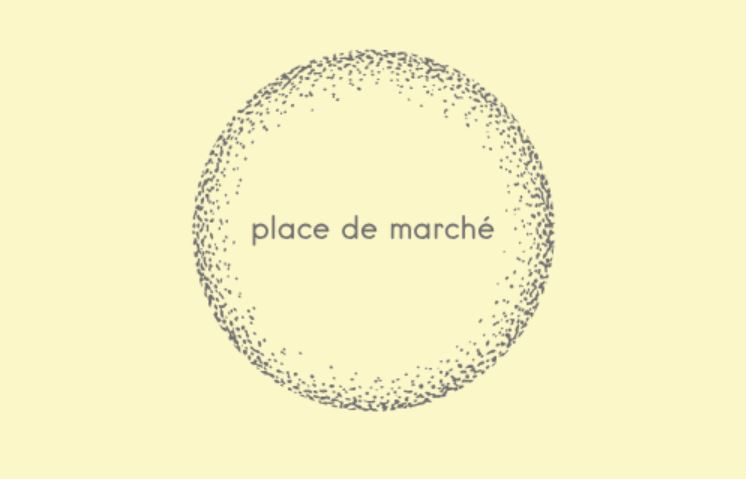

In [1]:
from IPython.display import Image
Image(r'C:\Users\betas\OneDrive\Desktop\formation data\projet 6\place marche.jpg')

On the marketplace, sellers offer items to buyers by posting a photo and description.

Currently, assigning an item's category is done manually by sellers, and is therefore unreliable. In addition, the volume of items is currently very small.

To make the user experience for sellers (facilitate the posting of new articles) and buyers (facilitate the search for products) as smooth as possible, and with a view to scaling up, it becomes necessary to automate this task.

Linda, Lead Data Scientist, therefore asks you to study the feasibility of an engine for classifying articles into different categories, with a sufficient level of precision.

# I- Exploratory Data Analysis(EDA)

## 1- Install & import necessary libraries

In [2]:
#!pip install sys
#!pip install tensorflow
#!pip install gensim
#!pip install gdown
#!pip install gunzip
#!pip install transformers
#!pip install tensorflow_hub
#!pip install opencv-python
#!pip install keras==2.6.*

In [3]:
# General libraries
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import spatial
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report
from sklearn.decomposition import LatentDirichletAllocation, NMF
from yellowbrick.cluster import SilhouetteVisualizer


# libraries for text data
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.probability import FreqDist
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess
from wordcloud import WordCloud

# libraries for visual data
import cv2
from matplotlib.image import imread

#Deep learning framework
import tensorflow
import tensorflow.keras
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50
from keras.applications.vgg16 import preprocess_input, decode_predictions
import transformers
from transformers import TFAutoModel, AutoTokenizer


# Libraries version
os.environ["TF_KERAS"]='1'
print('Python: {}'.format(sys.version))
print('Seaborn: {}'.format(sns.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('NLTK: {}'.format(nltk.__version__))
print('Gensim: {}'.format(gensim.__version__))
print('Tenserflow: {}'.format(tensorflow.__version__))
print('Keras: {}'.format(tensorflow.keras.__version__))

Python: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Seaborn: 0.11.1
Pandas: 1.2.4
Numpy: 1.20.1
NLTK: 3.6.1
Gensim: 4.1.2
Tenserflow: 2.7.0
Keras: 2.6.0


In [4]:
#Setting of displaying pandas dataframe
dictPdSettings = {'display.max_rows': 1000, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.4f' % x}

## 2- Download data

In [5]:
path = 'C:/Users/betas/Downloads/'
raw_df = pd.read_csv(path + 'flipkart_com-ecommerce_sample_1050.csv')

In [6]:
raw_df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [7]:
raw_df.shape

(1050, 15)

In [8]:
raw_df['product_name'][2]

'Eurospa Cotton Terry Face Towel Set'

In [9]:
list(set(raw_df['is_FK_Advantage_product']))

[False, True]

In [10]:
raw_df[raw_df.index==573]

uniq_id            crawl_timestamp  \
573  8fffcfe66dfde658580f98f6e28a6a46  2016-01-07 05:50:25 +0000   

                                           product_url  \
573  http://www.flipkart.com/gift-island-ast906-ana...   

                                     product_name  \
573  Gift Island AST906 Analog Watch  - For Women   

                                 product_category_tree               pid  \
573  ["Watches >> Wrist Watches >> Gift Island Wris...  WATE9ZYZRREUHQN4   

     retail_price  discounted_price                                 image  \
573         899.0             899.0  8fffcfe66dfde658580f98f6e28a6a46.jpg   

     is_FK_Advantage_product  \
573                    False   

                                           description       product_rating  \
573  Gift Island AST906 Analog Watch  - For Women -...  No rating available   

          overall_rating brand  \
573  No rating available   NaN   

                                product_specifications  
573  {"product_specification"=>[{"key"=>"Chronograp...

## 3- Variables understanding

In [11]:
info = {'null_values':raw_df.isna().sum(), 'variable_type':raw_df.dtypes, 'nunique':raw_df.nunique() }
info_df=pd.DataFrame(info)
info_df = info_df.style.set_properties(**{'text-align': 'left'}) 
info_df = info_df.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])]) 
info_df

- **uniq_id :** unique identifier for the product
- **crawl_timestamp:** 
- **product_url:** The link on the Flipkart platform to take users to a  specific product.
- **product_name:** Name of the product.
- **product_category_tree:** A top-down structure that generalizes where a product fits in the scheme of inventories.
- **pid:** A unique identifier value that a product gets assigned. 
- **retail_price:** Retal price of the product.
- **discounted_price:** Price after redeeming is discount on a product.
- **image:** Image of the product.
- **is_FK_Advantage_product:**
- **description:** A succinct summary of the product.
- **product_rating:** Rating the product has collected.
- **overall_rating:** The overall rating that a product has collected.
- **brand:** Brand with which the product is associated. 
- **product_specifications:**

In [12]:
df_desc = raw_df[['uniq_id','product_name','product_category_tree','description']]
df_desc

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree  \
0     ["Home Furnishing >> Curtains & Accessories >>...   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
...                                                 ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   

                                            description  
0     Key Features of Elegance Polyester Multicolor ...  
1     Specifications of Sathiyas Cotton Bath Towel (...  
2     Key Features of Eurospa Cotton Terry Face Towe...  
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  
4     Key Features of Jaipur Print Cotton Floral Kin...  
...                                                 ...  
1045  Oren Empower Extra Large Self Adhesive Sticker...  
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...  
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...  
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...  
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...  

[1050 rows x 4 columns]

# Natural Language (text)

# II- Text preprocessing
In this part we will use 3 variables :
- product_category_tree
- description
- product_name

For each feature, we will perform some preprocessing operations to prepare the data for modeling.

## 1- product_category_tree*** variable

In [13]:
df_desc['product_category_tree'].iloc[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [14]:
# Determining the maximum tree depth of categories
ser_depth = df_desc['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()
max_depth

6

In [15]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

def category_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df_desc['product_category_tree'].apply(lambda s: category_cleaning(s.index, s, name_level_cols))

df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df_desc.index)

In [16]:
display(df_cat_level.nunique(), df_cat_level.head())

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64

cat_level_0                             cat_level_1  \
0  Home Furnishing  Home Furnishing/Curtains & Accessories   
1        Baby Care              Baby Care/Baby Bath & Skin   
2        Baby Care              Baby Care/Baby Bath & Skin   
3  Home Furnishing               Home Furnishing/Bed Linen   
4  Home Furnishing               Home Furnishing/Bed Linen   

                                       cat_level_2  \
0  Home Furnishing/Curtains & Accessories/Curtains   
1      Baby Care/Baby Bath & Skin/Baby Bath Towels   
2      Baby Care/Baby Bath & Skin/Baby Bath Towels   
3              Home Furnishing/Bed Linen/Bedsheets   
4              Home Furnishing/Bed Linen/Bedsheets   

                                         cat_level_3  \
0  Home Furnishing/Curtains & Accessories/Curtain...   
1  Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...   
2  Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...   
3  Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...   
4  Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...   

                                         cat_level_4  \
0  Home Furnishing/Curtains & Accessories/Curtain...   
1  Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...   
2  Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...   
3  Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...   
4  Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...   

                                         cat_level_5  
0  Home Furnishing/Curtains & Accessories/Curtain...  
1  Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...  
2  Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...  
3  Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...  
4  Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...

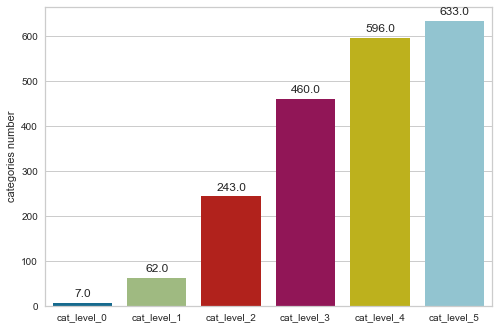

In [17]:
category = pd.DataFrame(data=df_cat_level.nunique(), columns=['categories number'])
ax = sns.barplot(y=category['categories number'], x=category.index)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [18]:
df_desc = pd.concat([df_desc, df_cat_level[['cat_level_0','cat_level_1']]], axis=1)
df_desc.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description      cat_level_0  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   

                              cat_level_1  
0  Home Furnishing/Curtains & Accessories  
1              Baby Care/Baby Bath & Skin  
2              Baby Care/Baby Bath & Skin  
3               Home Furnishing/Bed Linen  
4               Home Furnishing/Bed Linen

Text(0, 0.5, 'principal_category')

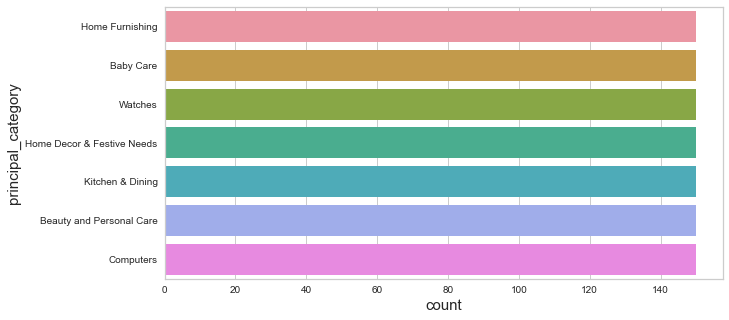

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_desc, y='cat_level_0', orient='h')
plt.xlabel('count', size=15)
plt.ylabel('principal_category', size=15)

Text(0, 0.5, 'Sub category 1')

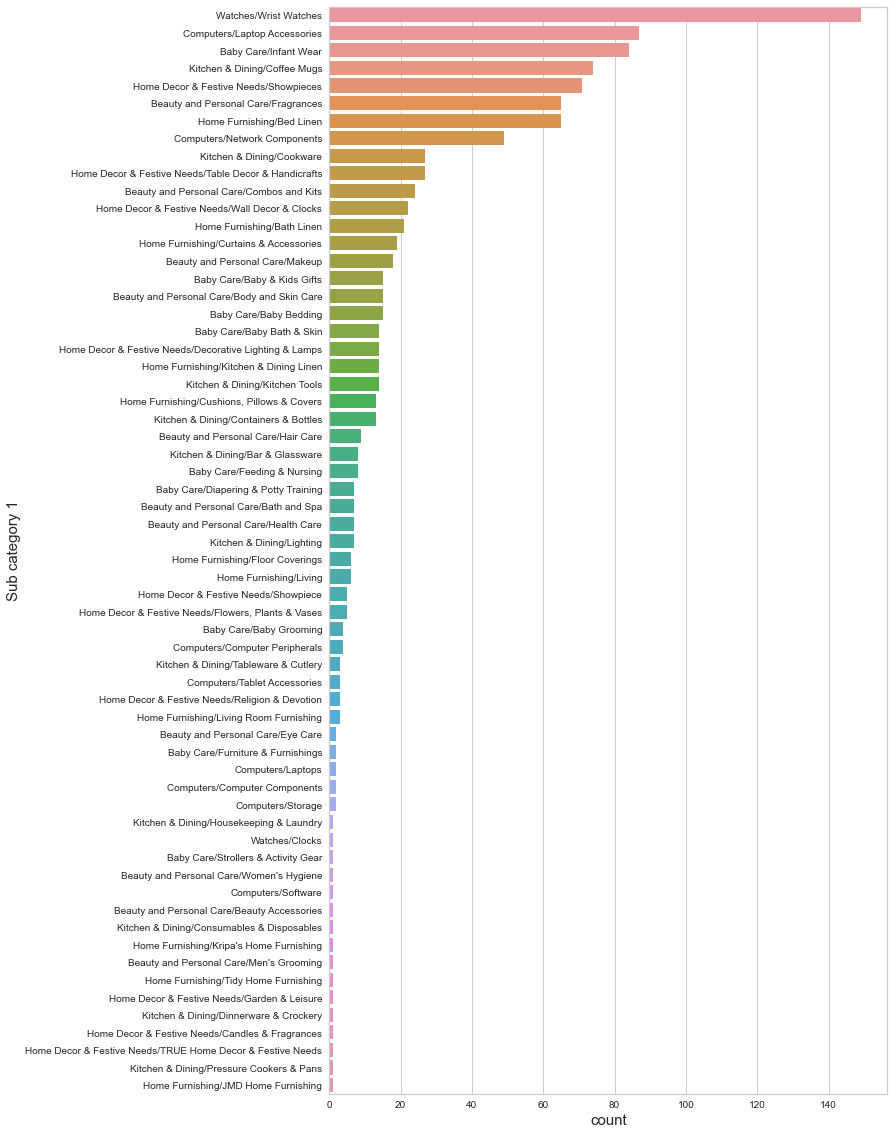

In [20]:
plt.figure(figsize=(10,20))
sns.countplot(data=df_desc, y='cat_level_1', order=df_desc['cat_level_1'].value_counts().index, orient='h')
plt.xlabel('count', size=15)
plt.ylabel('Sub category 1', size=15)

## 2 - ***description*** variable

In [21]:
df_desc['description'].iloc[20]

'Skmei AD1057-Dark-Orange Sports Analog-Digital Watch  - For Men, Boys - Buy Skmei AD1057-Dark-Orange Sports Analog-Digital Watch  - For Men, Boys  AD1057-Dark-Orange Online at Rs.1199 in India Only at Flipkart.com. Digital Chronograph, Alarm Watch, Light Function, Date & Month Display - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

In [22]:
# Tokenizer
def tokenizer_fct(sentence) :
    punctations = '''()-[]{},;:?./!%*~&_ç@=+\¤£$<>"'#`§�'''
    sentence_clean = ""
    for char in sentence : 
        if (char not in punctations) :
            sentence_clean = sentence_clean + char
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

#################################################################

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) and (not w.startswith("http"))]
    return lw

#################################################################

# Stop words
stop_w = set(stopwords.words('english'))
stop_w = stop_w.union({
    'product', 'free', 'buy', 'day', 'ship', 'replac', 'cash', 'price', 'guarante', 'sale', 'flipKartcom'
})
def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

#################################################################

# Lemmatizer (base d'un mot)
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

#################################################################

#Stemming 
def stem_fct(list_words):    
    stemmer = SnowballStemmer('english')
    stem_w = [stemmer.stem(w) for w in list_words]    
    return stem_w

#################################################################

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :    
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)    
    transf_desc_text = ' '.join(sw)    
    return transf_desc_text

#################################################################

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_stem_fct(desc_text) :  
    desc_text=''.join([i for i in desc_text if not i.isdigit()])
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)
    lem_w = lemma_fct(sw)   
    stem_w = stem_fct(lem_w)
    stem_w = stop_word_filter_fct(stem_w)
    transf_desc_text = ' '.join(stem_w)    
    return transf_desc_text

#################################################################

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :    
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)    
    return transf_desc_text

In [23]:
df_desc['description_lem'] = df_desc['description'].apply(lambda x : transform_bow_lem_stem_fct(x))
df_desc.head(3)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   

                                         description      cat_level_0  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   

                              cat_level_1  \
0  Home Furnishing/Curtains & Accessories   
1              Baby Care/Baby Bath & Skin   
2              Baby Care/Baby Bath & Skin   

                                     description_lem  
0  key featur eleg polyest multicolor abstract ey...  
1  specif sathiya cotton bath towel bath towel re...  
2  key featur eurospa cotton terri face towel set...

In [24]:
df_desc['description_lem'][20]

'skmei addarkorang sport analogdigit watch men boy skmei addarkorang sport analogdigit watch men boy addarkorang onlin india flipkartcom digit chronograph alarm watch light function date month display great discount genuin deliveri'

## 3 - ***product_name*** variable

In [25]:
df_desc['product_name'].iloc[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain'

In [26]:
df_desc['prod_name_lem'] = df_desc['product_name'].apply(lambda x : transform_bow_lem_stem_fct(x))
df_desc.head(3)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   

                                         description      cat_level_0  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   

                              cat_level_1  \
0  Home Furnishing/Curtains & Accessories   
1              Baby Care/Baby Bath & Skin   
2              Baby Care/Baby Bath & Skin   

                                     description_lem  \
0  key featur eleg polyest multicolor abstract ey...   
1  specif sathiya cotton bath towel bath towel re...   
2  key featur eurospa cotton terri face towel set...   

                                       prod_name_lem  
0  eleg polyest multicolor abstract eyelet door c...  
1                          sathiya cotton bath towel  
2                eurospa cotton terri face towel set

## 4- To get final data

In [27]:
df_desc['text'] = df_desc['description_lem'] + df_desc['prod_name_lem']
df_desc.drop(columns=['product_name','product_category_tree','description'], axis=1, inplace=True)
df_desc = df_desc.set_index('uniq_id')
df_desc['lengh_text'] = df_desc['text'].apply(lambda x: len(word_tokenize(x)))
df_desc.head(3)

cat_level_0  \
uniq_id                                             
55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                                             cat_level_1  \
uniq_id                                                                    
55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing/Curtains & Accessories   
7b72c92c2f6c40268628ec5f14c6d590              Baby Care/Baby Bath & Skin   
64d5d4a258243731dc7bbb1eef49ad74              Baby Care/Baby Bath & Skin   

                                                                    description_lem  \
uniq_id                                                                               
55b85ea15a1536d46b7190ad6fff8ce7  key featur eleg polyest multicolor abstract ey...   
7b72c92c2f6c40268628ec5f14c6d590  specif sathiya cotton bath towel bath towel re...   
64d5d4a258243731dc7bbb1eef49ad74  key featur eurospa cotton terri face towel set...   

                                                                      prod_name_lem  \
uniq_id                                                                               
55b85ea15a1536d46b7190ad6fff8ce7  eleg polyest multicolor abstract eyelet door c...   
7b72c92c2f6c40268628ec5f14c6d590                          sathiya cotton bath towel   
64d5d4a258243731dc7bbb1eef49ad74                eurospa cotton terri face towel set   

                                                                               text  \
uniq_id                                                                               
55b85ea15a1536d46b7190ad6fff8ce7  key featur eleg polyest multicolor abstract ey...   
7b72c92c2f6c40268628ec5f14c6d590  specif sathiya cotton bath towel bath towel re...   
64d5d4a258243731dc7bbb1eef49ad74  key featur eurospa cotton terri face towel set...   

                                  lengh_text  
uniq_id                                       
55b85ea15a1536d46b7190ad6fff8ce7         147  
7b72c92c2f6c40268628ec5f14c6d590          62  
64d5d4a258243731dc7bbb1eef49ad74         145

In [28]:
#To label category
encoder = LabelEncoder()
label_category = encoder.fit_transform(df_desc['cat_level_0'])
df_desc['label_category']=label_category
df_desc.head(3)

cat_level_0  \
uniq_id                                             
55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                                             cat_level_1  \
uniq_id                                                                    
55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing/Curtains & Accessories   
7b72c92c2f6c40268628ec5f14c6d590              Baby Care/Baby Bath & Skin   
64d5d4a258243731dc7bbb1eef49ad74              Baby Care/Baby Bath & Skin   

                                                                    description_lem  \
uniq_id                                                                               
55b85ea15a1536d46b7190ad6fff8ce7  key featur eleg polyest multicolor abstract ey...   
7b72c92c2f6c40268628ec5f14c6d590  specif sathiya cotton bath towel bath towel re...   
64d5d4a258243731dc7bbb1eef49ad74  key featur eurospa cotton terri face towel set...   

                                                                      prod_name_lem  \
uniq_id                                                                               
55b85ea15a1536d46b7190ad6fff8ce7  eleg polyest multicolor abstract eyelet door c...   
7b72c92c2f6c40268628ec5f14c6d590                          sathiya cotton bath towel   
64d5d4a258243731dc7bbb1eef49ad74                eurospa cotton terri face towel set   

                                                                               text  \
uniq_id                                                                               
55b85ea15a1536d46b7190ad6fff8ce7  key featur eleg polyest multicolor abstract ey...   
7b72c92c2f6c40268628ec5f14c6d590  specif sathiya cotton bath towel bath towel re...   
64d5d4a258243731dc7bbb1eef49ad74  key featur eurospa cotton terri face towel set...   

                                  lengh_text  label_category  
uniq_id                                                       
55b85ea15a1536d46b7190ad6fff8ce7         147               4  
7b72c92c2f6c40268628ec5f14c6d590          62               0  
64d5d4a258243731dc7bbb1eef49ad74         145               0

In [29]:
encoder.classes_

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

Text(0.5, 1.0, 'length text distribution')

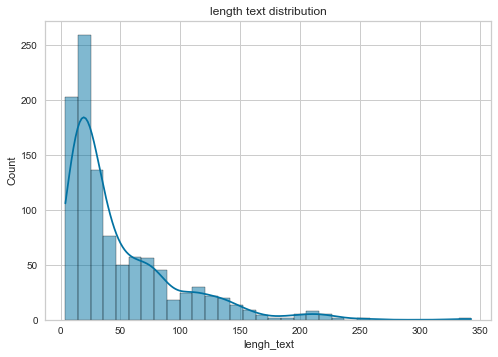

In [30]:
sns.histplot(data=df_desc, x=df_desc['lengh_text'], kde=True)
plt.title('length text distribution')

In [31]:
df_desc['description_lem'][20]

'skmei addarkorang sport analogdigit watch men boy skmei addarkorang sport analogdigit watch men boy addarkorang onlin india flipkartcom digit chronograph alarm watch light function date month display great discount genuin deliveri'

In [32]:
#Convert document into sequences of ints / idx / indices
idx = 0
word2idx = {}
tokenized_docs = []
for doc in df_desc['text'] :
    words = word_tokenize(doc.lower())
    doc_as_int = []
    for word in words : 
        if word not in word2idx : 
            word2idx[word] = idx
            idx += 1
        # save for later
        doc_as_int.append(word2idx[word])
    tokenized_docs.append(doc_as_int)  

In [33]:
word2idx

{'key': 0,
 'featur': 1,
 'eleg': 2,
 'polyest': 3,
 'multicolor': 4,
 'abstract': 5,
 'eyelet': 6,
 'door': 7,
 'curtain': 8,
 'floral': 9,
 'curtaineleg': 10,
 'height': 11,
 'pack': 12,
 'enhanc': 13,
 'look': 14,
 'interiorsthi': 15,
 'made': 16,
 'high': 17,
 'qualiti': 18,
 'fabricit': 19,
 'style': 20,
 'stitch': 21,
 'metal': 22,
 'ringit': 23,
 'make': 24,
 'room': 25,
 'environ': 26,
 'romant': 27,
 'lovingthi': 28,
 'ant': 29,
 'wrinkl': 30,
 'anti': 31,
 'shrinkag': 32,
 'apparanceg': 33,
 'home': 34,
 'bright': 35,
 'modernist': 36,
 'appeal': 37,
 'design': 38,
 'surreal': 39,
 'attent': 40,
 'sure': 41,
 'steal': 42,
 'heart': 43,
 'contemporari': 44,
 'valanc': 45,
 'slide': 46,
 'smooth': 47,
 'draw': 48,
 'apart': 49,
 'first': 50,
 'thing': 51,
 'morn': 52,
 'welcom': 53,
 'sun': 54,
 'ray': 55,
 'want': 56,
 'wish': 57,
 'good': 58,
 'whole': 59,
 'world': 60,
 'close': 61,
 'even': 62,
 'creat': 63,
 'special': 64,
 'moment': 65,
 'joyous': 66,
 'beauti': 67,
 'giv

In [34]:
# Reverse mapping
idx2word = {v:k for k, v in word2idx.items()}
idx2word

{0: 'key',
 1: 'featur',
 2: 'eleg',
 3: 'polyest',
 4: 'multicolor',
 5: 'abstract',
 6: 'eyelet',
 7: 'door',
 8: 'curtain',
 9: 'floral',
 10: 'curtaineleg',
 11: 'height',
 12: 'pack',
 13: 'enhanc',
 14: 'look',
 15: 'interiorsthi',
 16: 'made',
 17: 'high',
 18: 'qualiti',
 19: 'fabricit',
 20: 'style',
 21: 'stitch',
 22: 'metal',
 23: 'ringit',
 24: 'make',
 25: 'room',
 26: 'environ',
 27: 'romant',
 28: 'lovingthi',
 29: 'ant',
 30: 'wrinkl',
 31: 'anti',
 32: 'shrinkag',
 33: 'apparanceg',
 34: 'home',
 35: 'bright',
 36: 'modernist',
 37: 'appeal',
 38: 'design',
 39: 'surreal',
 40: 'attent',
 41: 'sure',
 42: 'steal',
 43: 'heart',
 44: 'contemporari',
 45: 'valanc',
 46: 'slide',
 47: 'smooth',
 48: 'draw',
 49: 'apart',
 50: 'first',
 51: 'thing',
 52: 'morn',
 53: 'welcom',
 54: 'sun',
 55: 'ray',
 56: 'want',
 57: 'wish',
 58: 'good',
 59: 'whole',
 60: 'world',
 61: 'close',
 62: 'even',
 63: 'creat',
 64: 'special',
 65: 'moment',
 66: 'joyous',
 67: 'beauti',
 68: 

## 5 - Word frequency

### a - Total freuency

In [35]:
# creation of a corpus of all the descriptions
corpus = ' '.join(df_desc['text'].values)
print(f"The total corpus contains {len(corpus.split())} words.")
print('*'*20)
corpus

The total corpus contains 51563 words.
********************


'key featur eleg polyest multicolor abstract eyelet door curtain floral curtaineleg polyest multicolor abstract eyelet door curtain height pack curtain enhanc look interiorsthi curtain made high qualiti polyest fabricit featur eyelet style stitch metal ringit make room environ romant lovingthi curtain ant wrinkl anti shrinkag eleg apparanceg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smooth draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyous beauti given sooth print bring home eleg curtain soft filter light room get right amount sunlightspecif eleg polyest multicolor abstract eyelet door curtain height pack general brand eleg design door type eyelet model name abstract polyest door curtain set model duster color multicolor dimens length box number content packag pack packag curtain bodi design materi polyesteleg polyest multicolor abstract eyelet d

In [36]:
## Calculate words frequency
word_corpus = word_tokenize(corpus)
word_frequency = pd.Series(nltk.FreqDist(word_corpus))
word_frequency = pd.DataFrame(data=word_frequency.sort_values(ascending=False), columns=['frequency']).reset_index()
word_frequency.rename({'index' : 'word'}, axis=1, inplace=True)
word_frequency

word  frequency
0             mug        516
1           watch        510
2     flipkartcom        467
3             set        443
4            babi        411
...           ...        ...
5049          blu          1
5050    etcspecif          1
5051         pray          1
5052      suspend          1
5053   genuinvrct          1

[5054 rows x 2 columns]

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

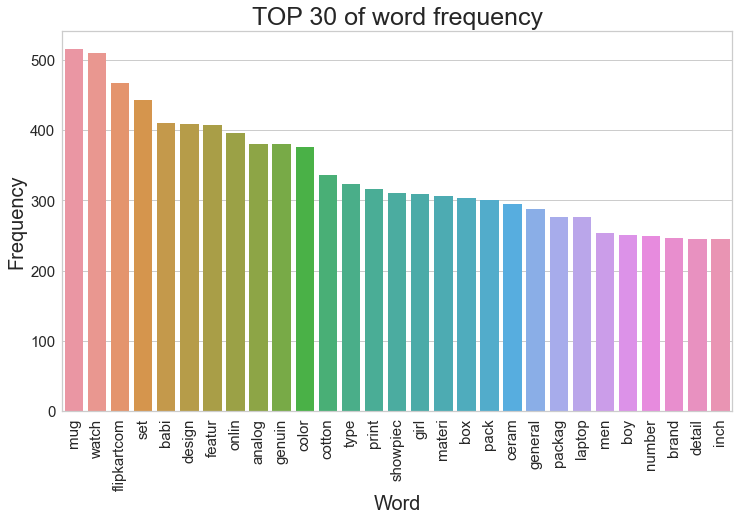

In [37]:
plt.figure(figsize=(12,7))
sns.barplot(data=word_frequency[0:29], x='word', y='frequency')
plt.xticks(rotation=90)
plt.title('TOP 30 of word frequency', size=25)
plt.xlabel('Word', size=20)
plt.xticks(size=15, rotation=90)
plt.ylabel('Frequency', size=20)
plt.yticks(size=15)


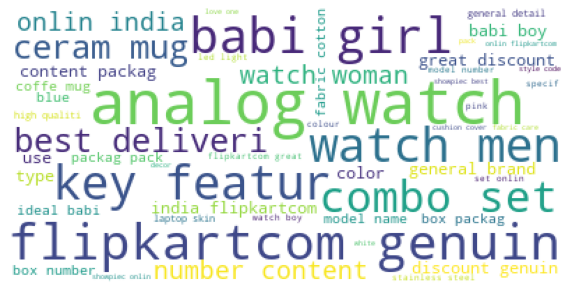

In [38]:
plt.figure(figsize=(10,15))
word_cloud = WordCloud(background_color='white', max_words=50).generate(corpus)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

### b - Freuency per category

In [39]:
'''Takes a groupby made on a series of texts (non tokenized),
(-> for example : gb = df_desc_cat.groupby('category')['desc_clean'])
extracts the n top words and plots a wordcloud of the (n_top_words)
top words for each topic.
'''



def plot_wordclouds_from_gb(gb, n_top_words, n_rows=1, figsize=(15,5),
                             backgnd_color='black', cmap='Dark2',
                            random_state=None):

    fig = plt.figure(figsize=figsize)

    for i, tup in enumerate(gb,1):
        n_topic, ser_texts = tup
        # creation of a corpus of all the cleaned descriptions and product_names
        corpus = ' '.join(ser_texts.values)
        # tokenizing the words in the cleaned corpus
        tokenizer = nltk.RegexpTokenizer(r'[a-z]+')
        li_words = tokenizer.tokenize(corpus.lower())
        # counting frequency of each word
        ser_freq = pd.Series(nltk.FreqDist(li_words))

        wc = WordCloud(stopwords=None, background_color=backgnd_color,
                        colormap=cmap, max_font_size=200,
                        random_state=14)
        ser_topic = ser_freq\
            .sort_values(ascending=False)[0:n_top_words]
        wc.generate(' '.join(list(ser_topic.index)))

        n_tot = len(gb)
        n_cols = (n_tot//n_rows)+((n_tot%n_rows)>0)*1
        ax = fig.add_subplot(n_rows,n_cols,i)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.tight_layout()
        plt.title(n_topic, fontweight='bold')

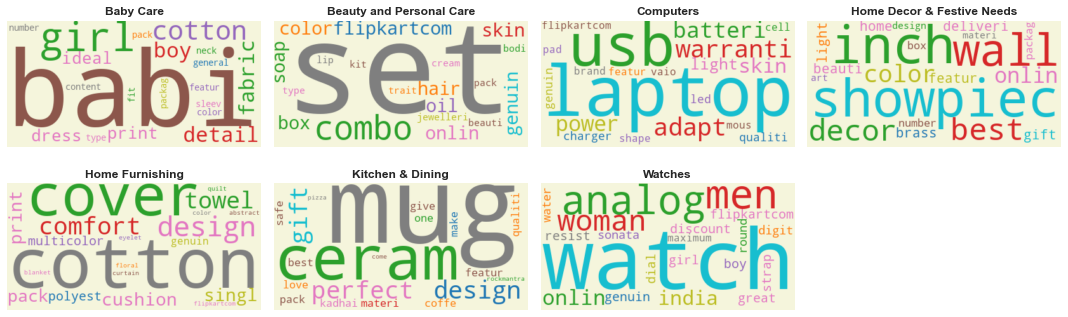

In [40]:
gb = df_desc.groupby('cat_level_0')['text']
plot_wordclouds_from_gb(gb, n_top_words=20, n_rows=2, figsize=(15,5),
                        backgnd_color='beige', cmap='tab10', random_state=14)

### Text Vectorization 

In [41]:
def vector_df(vectorizer, column):
    
    vectorized_df = vectorizer.fit_transform(df_desc[column])
    print('the shape of vectorized matrix is:', vectorized_df.shape )
    print('the amount of values different from 0 is :', ((vectorized_df !=0).sum()/np.prod(vectorized_df.shape))*100, '%')
    feature_names = vectorizer.get_feature_names()
    vectorized_df = pd.DataFrame(data=vectorized_df.todense().tolist(), columns=feature_names)
    return vectorized_df

# III - Text modelling
In this par of the project, we will create for all products, a vector of features using :
- Bag Of Words (countvectorizer & TF-IDF)
- Word embedding models (Word2Vec, Bert, USE)

After that we will reduce obtianed matrix with t-SNE and make clustring.
Then, we will calculate **ARI score** and **confusion matrix** to compare truth categories with t-SNE labels to study the feasibility of classification.

Furthermore, we use topic modelling such as LDA(Latent Dirichlet Allocation) & NMF(Non-Negative Matrix Factorization)


## 1 - Useful functions

In [42]:
num_labels=len(list(set(df_desc['cat_level_0'])))

def silhouette_visualizer(vectorized_data):
    """
    """
    tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1500, init='random', learning_rate=200)
    X_tsne = tsne.fit_transform(vectorized_data)
    tsne_columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)] 
    X_tsne  = pd.DataFrame (data = X_tsne, columns= tsne_columns)
      

    num_labels=len(list(set(df_desc['cat_level_0'])))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    plt.figure(figsize=(5,6))
    plt.style.use('seaborn-whitegrid')

    silhouette_visualizer = SilhouetteVisualizer(cls)
    silhouette_visualizer.fit(X_tsne)
    silhouette_visualizer.show()

######################################################################################

def tsne_text(vectorized_data, method): 
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1500, init='random', learning_rate=200)
    X_tsne = tsne.fit_transform(vectorized_data)
    tsne_columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)] 
    X_tsne  = pd.DataFrame (data = X_tsne, columns= tsne_columns)
   
    
    time1 = time.time()
    num_labels=len(list(set(df_desc['cat_level_0'])))
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    X_tsne = pd.merge(X_tsne, df_desc[['label_category']], on=X_tsne.index)
    X_tsne.drop('key_0', axis=1, inplace=True)
    X_tsne['cluster']=cls.labels_
    ARI = np.round(adjusted_rand_score(label_category, cls.labels_),3)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
  
    plt.style.use('seaborn-whitegrid')   
    plt.figure (figsize = (16,14))
    
    plt.subplot(2,2,1)
    sns.scatterplot (data=X_tsne, x='DIM1' , y='DIM2', hue='label_category', palette='rainbow')
    plt.title('t_SNE projection with '+ str(method) + '\n original categories', size=20)
    plt.xlabel('DIM 1', size=15)
    plt.ylabel('DIM 2', size=15)
 
    plt.subplot(2,2,2)
    sns.scatterplot (data=X_tsne, x='DIM1' , y='DIM2', hue='cluster', palette='rainbow')
    plt.title('t_SNE projection with '+ str(method) + '\n KMeans clustering', size=20)
    plt.xlabel('DIM 1', size=15)
    plt.ylabel('DIM 2', size=15)

    plt.subplot(2,2,3)
    sns.countplot(data=X_tsne, y='label_category', orient='h')
    plt.xlabel('count', size=15)
    plt.ylabel('label_category', size=15)

    plt.subplot(2,2,4)
    sns.countplot(data=X_tsne, y='cluster', orient='h')
    plt.xlabel('count', size=15)
    plt.ylabel('cluster', size=15)
    plt.show()

    
###########################################################################

def matrix(vectorized_data):
    tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1500, init='random', learning_rate=200)
    X_tsne = tsne.fit_transform(vectorized_data)
    
    # Kmeans
    cls = KMeans(n_clusters=7, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    # Prep
    k_labels = cls.labels_  # Get cluster labels
    k_labels_matched = np.empty_like(k_labels)
   
    # For each cluster label...
    for k in np.unique(k_labels):
        # ...find and assign the best-matching truth label
        match_nums = [np.sum((k_labels==k)*(df_desc['label_category']==t)) for t in np.unique(df_desc['label_category'])]
        k_labels_matched[k_labels==k] = np.unique(df_desc['label_category'])[np.argmax(match_nums)]
    
    # Compute confusion matrix
    cm = confusion_matrix(df_desc['label_category'].tolist(), k_labels_matched, labels=df_desc['label_category'].unique())

    # Plot confusion matrix
    plt.imshow(cm,interpolation='none',cmap='Blues')
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, z, ha='center', va='center')
    plt.xlabel("kmeans label")
    plt.ylabel("truth label")
    plt.show()
    
def conf_mat(vectorized_data) :
    tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1500, init='random', learning_rate=200)
    X_tsne = tsne.fit_transform(vectorized_data)
    
    # Kmeans
    cls = KMeans(n_clusters=7, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    # Prep
    y_pred = cls.labels_  # Get cluster labels
    y_true = df_desc['label_category'].to_list()
    
    
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [6, 5, 4, 3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    print(labels['y_pred_transform'])
    conf_mat = confusion_matrix(y_true, labels['y_pred_transform'])
    print(conf_mat)
    print()
    print(classification_report(y_true, labels['y_pred_transform']))

    df_cm = pd.DataFrame(conf_mat, index = [label for label in df_desc['cat_level_0'].unique()],
                  columns = [i for i in "0123456"])
    sns.heatmap(df_cm, annot=True, cmap="Blues")    



## 2 -  Bag Of Words 

### a - Count_vectorizer

In [43]:
# To create model (token = one word)
count_vect = CountVectorizer(stop_words=stop_w,  max_df=0.95, min_df=1, strip_accents='ascii', lowercase=True)
#To display word vector for each product
columns = ['text','description_lem', 'prod_name_lem']
for column in columns : 
    print (f'Bag Of Word of {column} column')
    vectorized_df = vector_df(count_vect, column)
    print('\n') 
    
# To create model (token = two words
count_vect2 = CountVectorizer(stop_words=stop_w, ngram_range=(2,2), max_df=0.95, min_df=1)
count_df2 = vector_df(count_vect2, 'text')
count_df2.head(3)
   


Bag Of Word of text column
the shape of vectorized matrix is: (1050, 5050)
the amount of values different from 0 is : 0.5193587930221594 %


Bag Of Word of description_lem column
the shape of vectorized matrix is: (1050, 4398)
the amount of values different from 0 is : 0.5892505251304705 %


Bag Of Word of prod_name_lem column
the shape of vectorized matrix is: (1050, 1842)
the amount of values different from 0 is : 0.30753321958533686 %


the shape of vectorized matrix is: (1050, 18622)
the amount of values different from 0 is : 0.17862129278733296 %


aaa batteri  aapno rajasthan  aapno rajasthanspecif  aari embroid  \
0            0                0                      0             0   
1            0                0                      0             0   
2            0                0                      0             0   

   aari embroideri  aarika self  abil aid  abil lightweight  \
0                0            0         0                 0   
1                0            0         0                 0   
2                0            0         0                 0   

   abklgrngrngrn box  abklgrngrngrn brand  ...  zipper brand  zipper compart  \
0                  0                    0  ...             0               0   
1                  0                    0  ...             0               0   
2                  0                    0  ...             0               0   

   zone pillow  zone print  zone protector  zoom type  zora laptop  \
0            0           0               0          0            0   
1            0           0               0          0            0   
2            0           0               0          0            0   

   zyxel data  zyxel pla  zyxel vmgba  
0           0          0            0  
1           0          0            0  
2           0          0            0  

[3 rows x 18622 columns]

Bag Of Word of text column
the shape of vectorized matrix is: (1050, 5050)
the amount of values different from 0 is : 0.5193587930221594 %
ARI :  0.423 time :  1.0


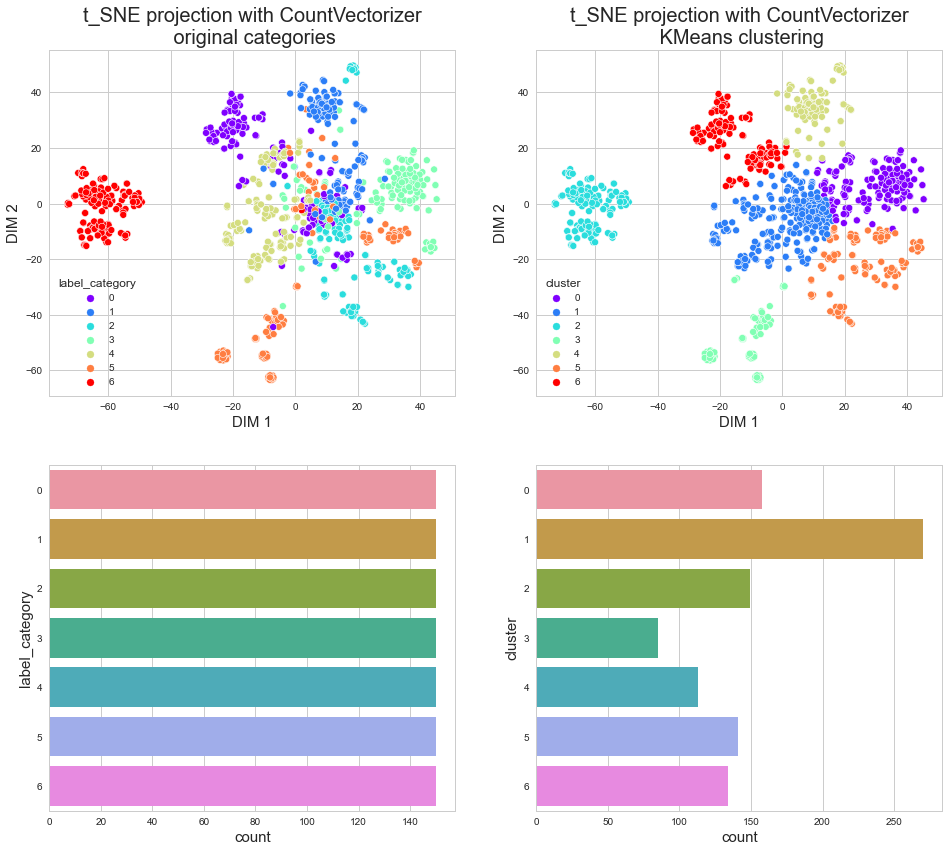

Bag Of Word of description_lem column
the shape of vectorized matrix is: (1050, 4398)
the amount of values different from 0 is : 0.5892505251304705 %
ARI :  0.451 time :  1.0


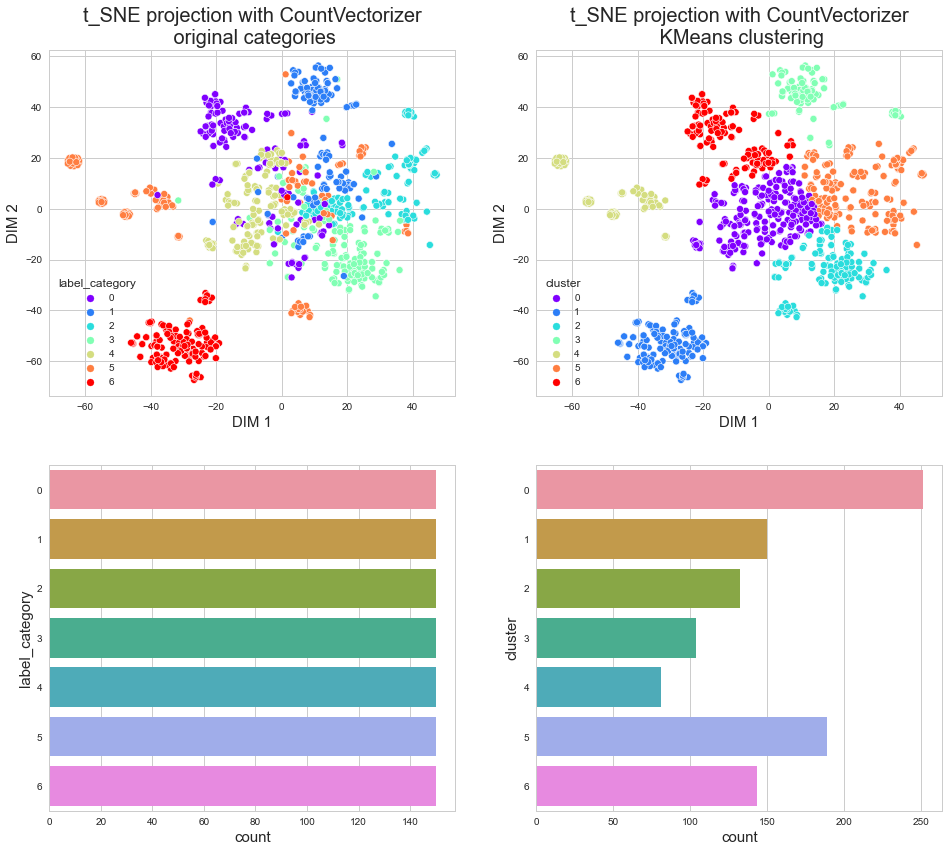

Bag Of Word of prod_name_lem column
the shape of vectorized matrix is: (1050, 1842)
the amount of values different from 0 is : 0.30753321958533686 %
ARI :  0.409 time :  1.0


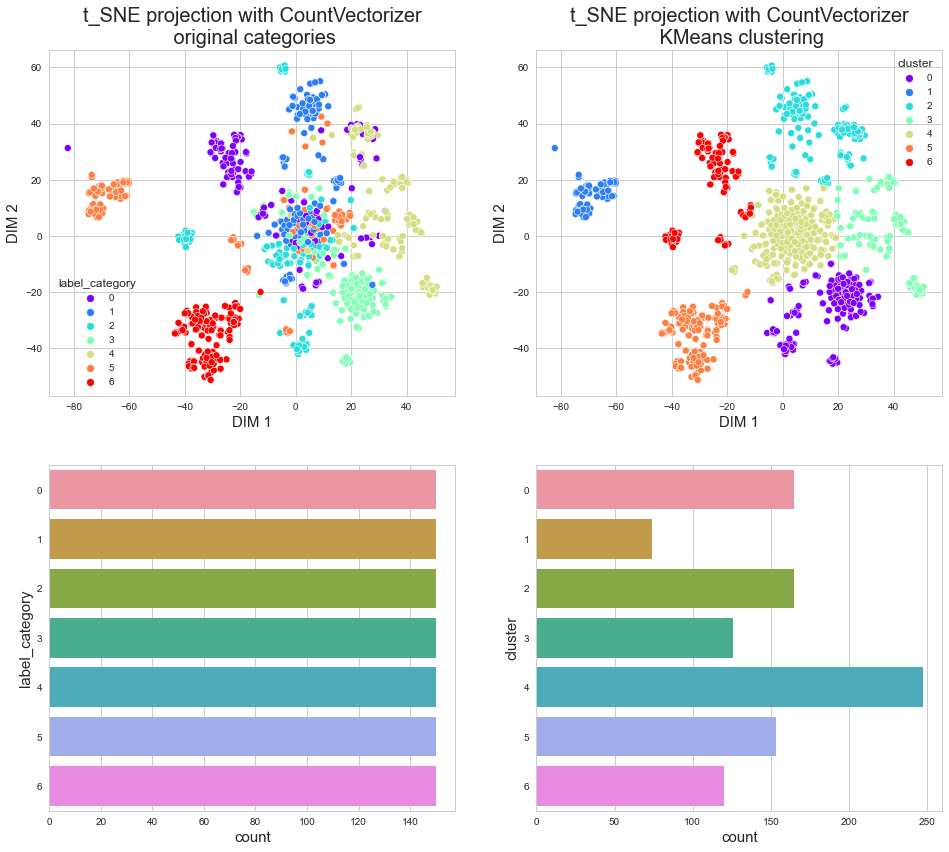

In [44]:
# Clustering with t-SNE reduction
for column in columns : 
    print (f'Bag Of Word of {column} column')
    vectorized_df = vector_df(count_vect, column)
    tsne_count = tsne_text(vectorized_df, 'CountVectorizer')   

the shape of vectorized matrix is: (1050, 5050)
the amount of values different from 0 is : 0.5193587930221594 %


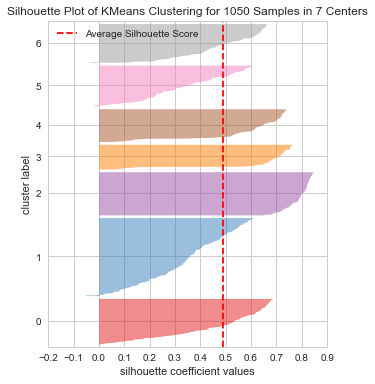

In [45]:
silhouette_visualizer(vector_df(count_vect, 'text'))

Bag Of Word of text column
the shape of vectorized matrix is: (1050, 18622)
the amount of values different from 0 is : 0.17862129278733296 %
ARI :  0.201 time :  1.0


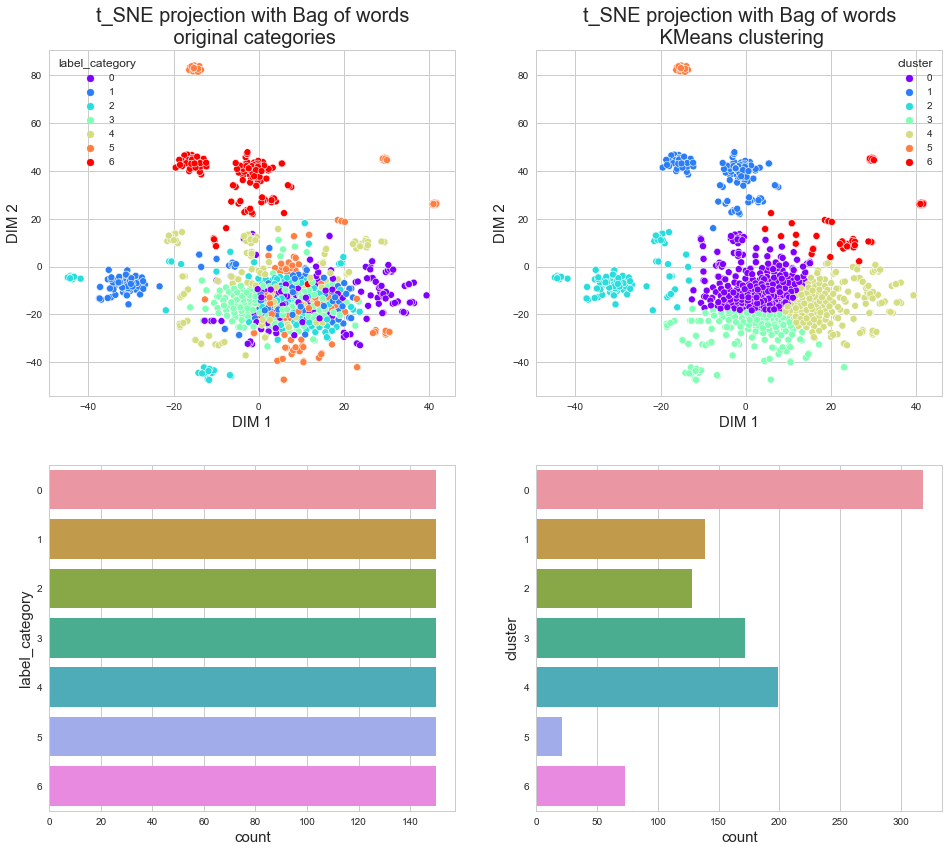

Bag Of Word of description_lem column
the shape of vectorized matrix is: (1050, 17197)
the amount of values different from 0 is : 0.1864334033898493 %
ARI :  0.201 time :  1.0


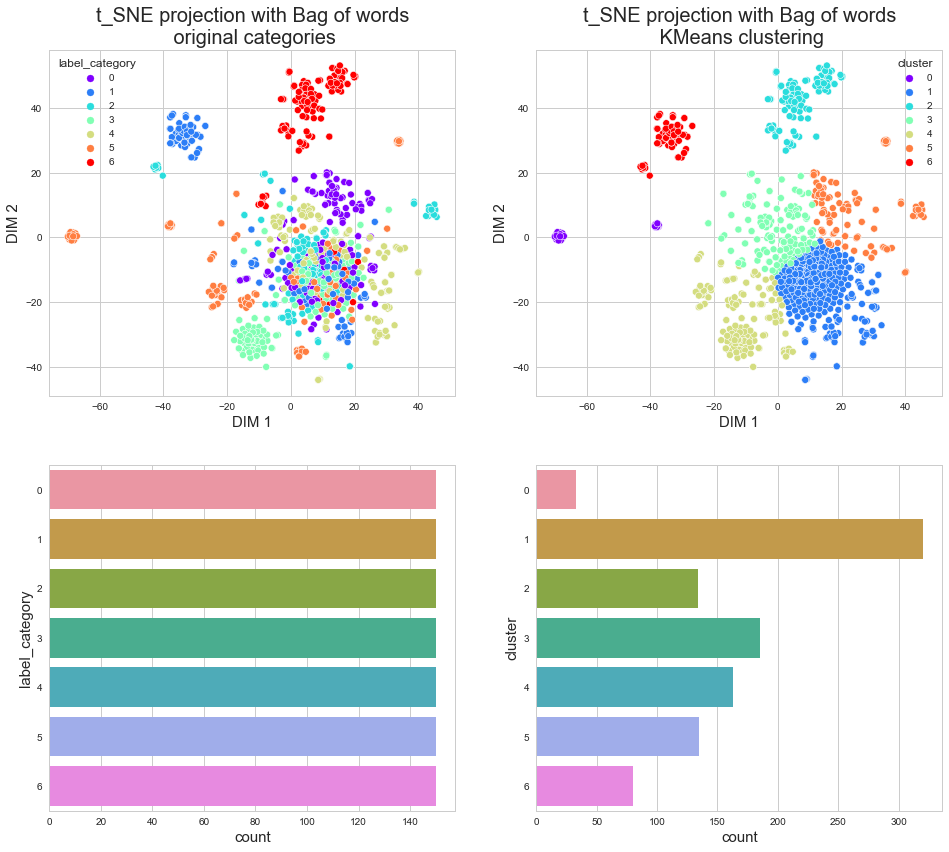

Bag Of Word of prod_name_lem column
the shape of vectorized matrix is: (1050, 3126)
the amount of values different from 0 is : 0.15257593760472837 %
ARI :  0.169 time :  1.0


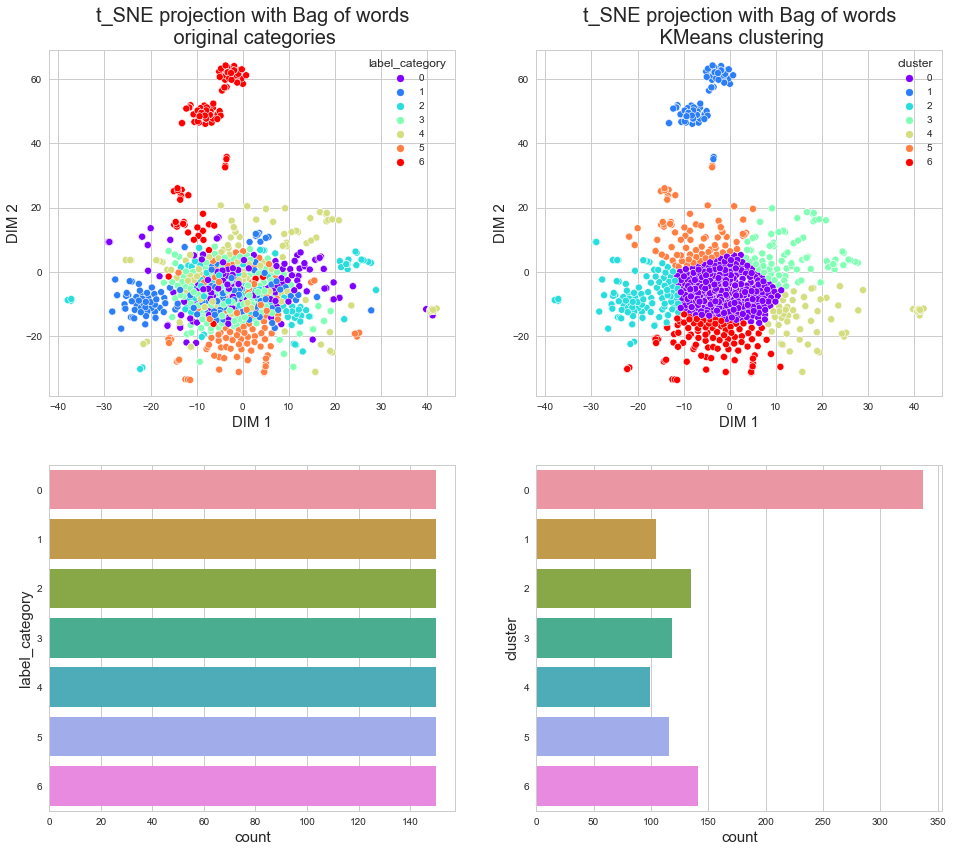

In [46]:
# Count vectorizer n-gram=2
for column in columns : 
    print (f'Bag Of Word of {column} column')
    vectorized_df = vector_df(count_vect2, column)
    tsne_count = tsne_text(vectorized_df, 'Bag of words')   

### b - TF-IDF

In [47]:
# To create model (token = one word)
tfidf_vect= TfidfVectorizer(stop_words=stop_w, max_df=0.95, min_df=1, sublinear_tf=True)
#To display word vector for each product
columns = ['text','description_lem', 'prod_name_lem']
for column in columns : 
    print (f'TF-IDF of {column} column')
    vectorised_df = vector_df(tfidf_vect, column)
    print('\n')

TF-IDF of text column
the shape of vectorized matrix is: (1050, 5052)
the amount of values different from 0 is : 0.5191720393620631 %


TF-IDF of description_lem column
the shape of vectorized matrix is: (1050, 4400)
the amount of values different from 0 is : 0.589004329004329 %


TF-IDF of prod_name_lem column
the shape of vectorized matrix is: (1050, 1842)
the amount of values different from 0 is : 0.30753321958533686 %




TF-IDF text column
the shape of vectorized matrix is: (1050, 5052)
the amount of values different from 0 is : 0.5191720393620631 %
ARI :  0.552 time :  1.0


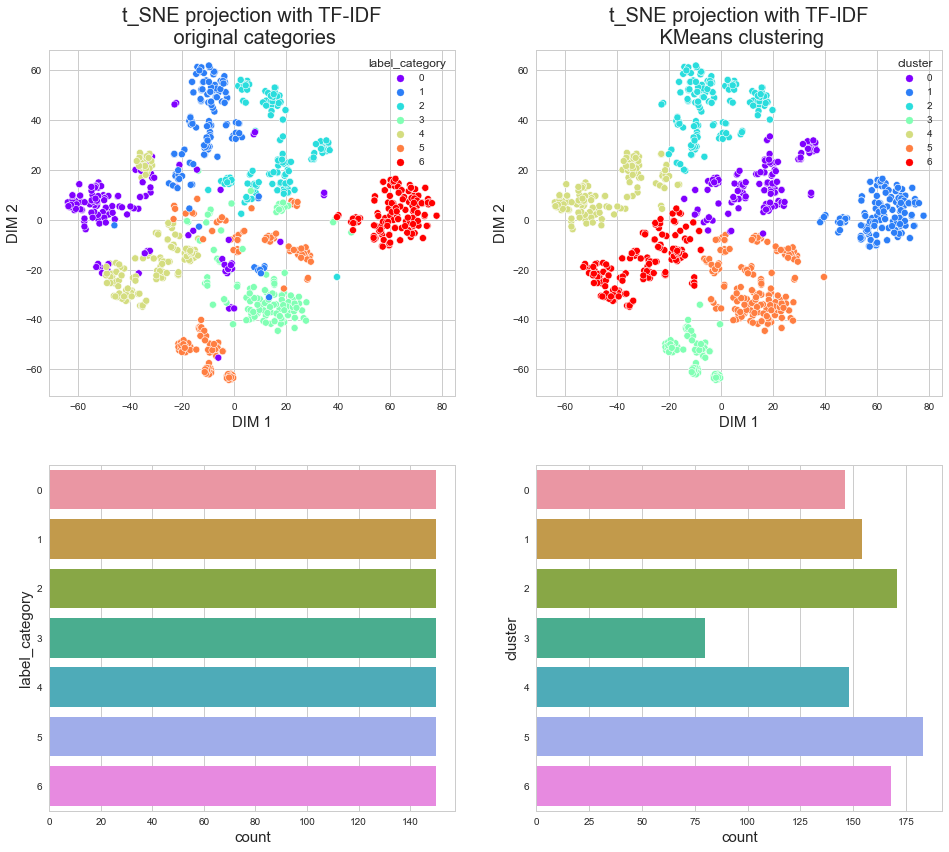

TF-IDF description_lem column
the shape of vectorized matrix is: (1050, 4400)
the amount of values different from 0 is : 0.589004329004329 %
ARI :  0.527 time :  1.0


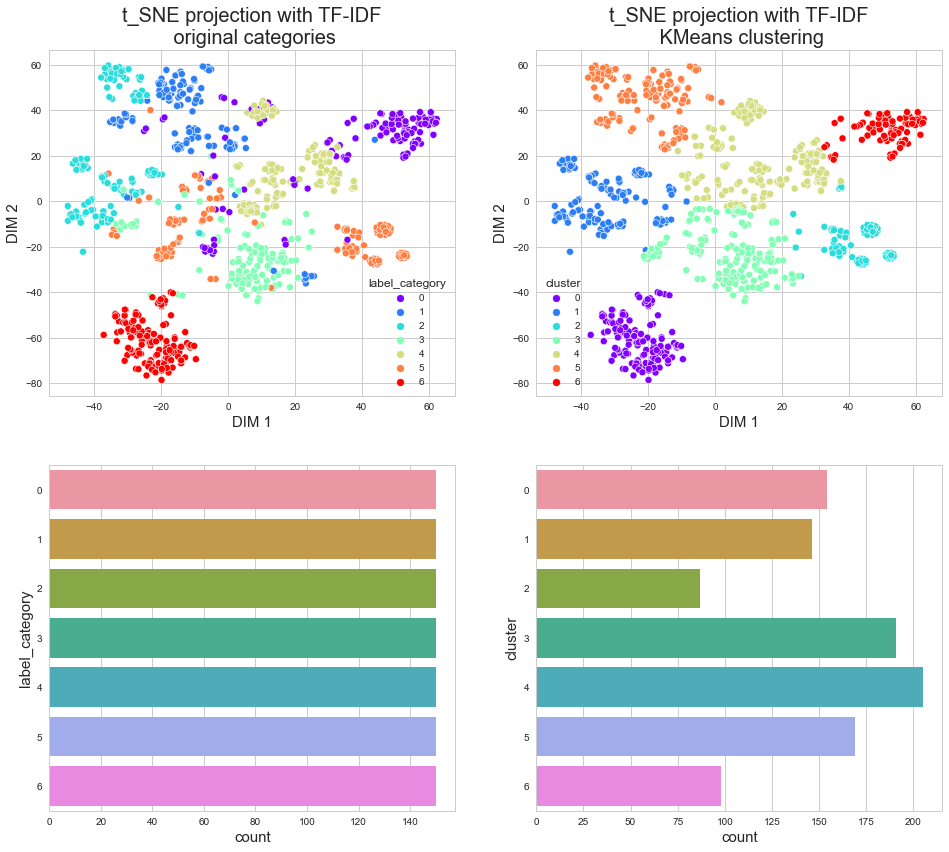

TF-IDF prod_name_lem column
the shape of vectorized matrix is: (1050, 1842)
the amount of values different from 0 is : 0.30753321958533686 %
ARI :  0.486 time :  1.0


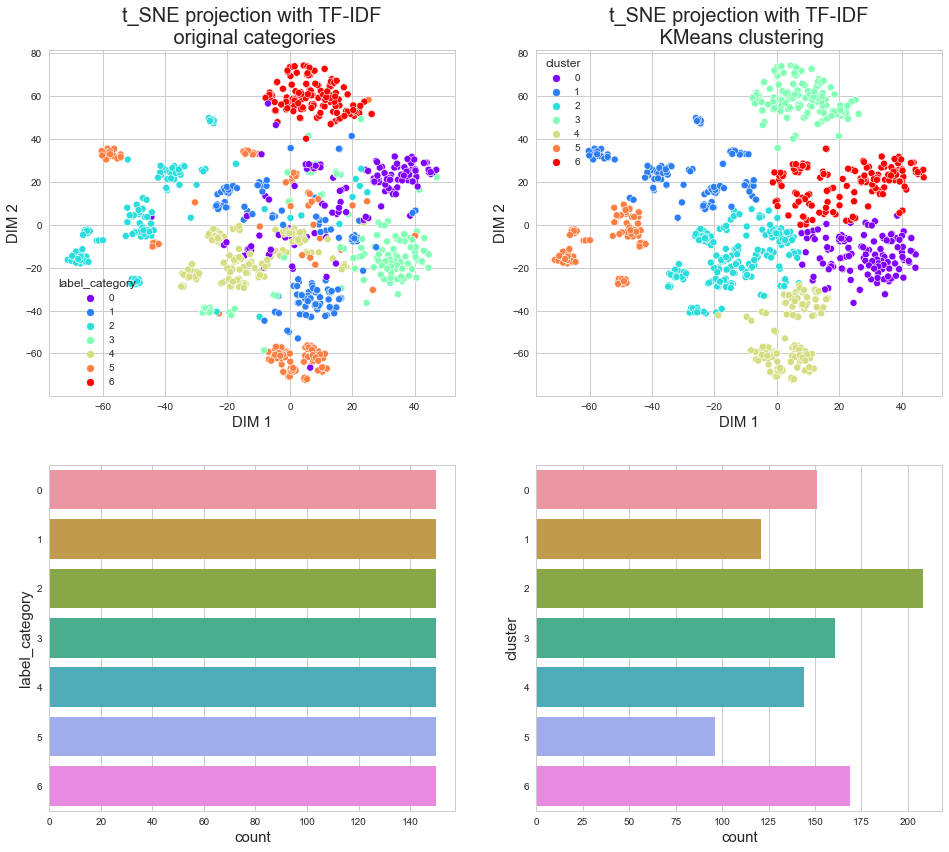

In [48]:
# Clustering with t-SNE reduction
for column in columns : 
    print (f'TF-IDF {column} column')
    vectorized_df = vector_df(tfidf_vect, column)
    tsne_count = tsne_text(vectorized_df, 'TF-IDF')

In [49]:
tfidf_df = vector_df(tfidf_vect, 'text')
tfidf_feature_names = tfidf_vect.get_feature_names()
transformation = []
for i, el  in enumerate(tfidf_df.iloc[0]):
    if el != 0:
        transformation.append((tfidf_feature_names[i], el))
pd.DataFrame(transformation, columns=['word', 'tfidf']).sort_values(by='tfidf', ascending=False).head(10)

the shape of vectorized matrix is: (1050, 5052)
the amount of values different from 0 is : 0.5191720393620631 %


word     tfidf
19     curtain  0.257131
30      eyelet  0.227294
23        door  0.217627
64     polyest  0.199270
26        eleg  0.178626
0     abstract  0.168428
24        draw  0.158276
12      bright  0.146376
58        morn  0.138210
59  multicolor  0.138108

### Confusion matrix 

Correspondance des clusters :  [6, 5, 4, 3, 1, 2, 0]
0       0
1       1
2       1
3       0
4       0
       ..
1045    2
1046    2
1047    2
1048    2
1049    2
Name: y_pred_transform, Length: 1050, dtype: int64
[[ 14 109  16   1   6   0   4]
 [  2  17  10   0 118   0   3]
 [  0   0   2   0  46   0 102]
 [ 14   0 109   4   1   4  18]
 [130  20   0   0   0   0   0]
 [  8   2  46  75   0   0  19]
 [  0   0   0   0   0 150   0]]

              precision    recall  f1-score   support

           0       0.08      0.09      0.09       150
           1       0.11      0.11      0.11       150
           2       0.01      0.01      0.01       150
           3       0.05      0.03      0.03       150
           4       0.00      0.00      0.00       150
           5       0.00      0.00      0.00       150
           6       0.00      0.00      0.00       150

    accuracy                           0.04      1050
   macro avg       0.04      0.04      0.04      1050
weighted avg       0.04  

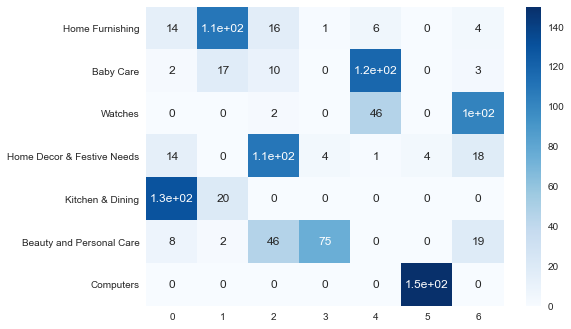

In [50]:
#Confusion matrix
conf_mat(tfidf_df)

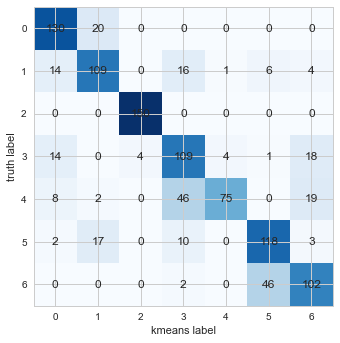

In [51]:
#Confusion matrix
matrix(tfidf_df)

## 3 - Topic modelling (LDA & NMF)

In [52]:
n_samples = len(df_desc)
n_features = 1000
n_topics = 7
n_top_words = 10
tfidf_feature_names = tfidf_vect.get_feature_names_out()


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
############################################################

def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [53]:
# Create models
# LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=45
)


nmf = NMF(
    n_components=n_topics,
    random_state=1, 
    beta_loss='kullback-leibler',
    solver='mu',    
    alpha=0.1,
    l1_ratio=0.5
)



In [54]:
# fit models 
lda = lda.fit(tfidf_df)
nmf = nmf.fit(tfidf_df)

In [55]:
lda_topics = display_topics(lda, tfidf_vect.get_feature_names(), n_top_words)
lda_topics

Topic 0:
flipkartcom genuin deliveritenda tenda combo kit soap cell bulb mxofer
Topic 1:
watch analog sticker onlin men showpiec flipkartcom genuin design multicolor
Topic 2:
brnc wra doll uvshield herbal niko gel sunscreen ibal deliveriibal
Topic 3:
mug rockmantra ceram porcelain thrill stay toodishwash perman start fresh
Topic 4:
kadhai deliveri best onlin hard anodis metallino kosher kalash intex
Topic 5:
bracl shadow player luv runway wetdri wifi smart router deliverilinksi
Topic 6:
set babi combo flipkartcom cotton towel detail genuin girl fabric


Fitting the NMF model (kullback-leibler) with tf-idf features, n_samples=1050 and n_features=1000...
done in 0.000s.


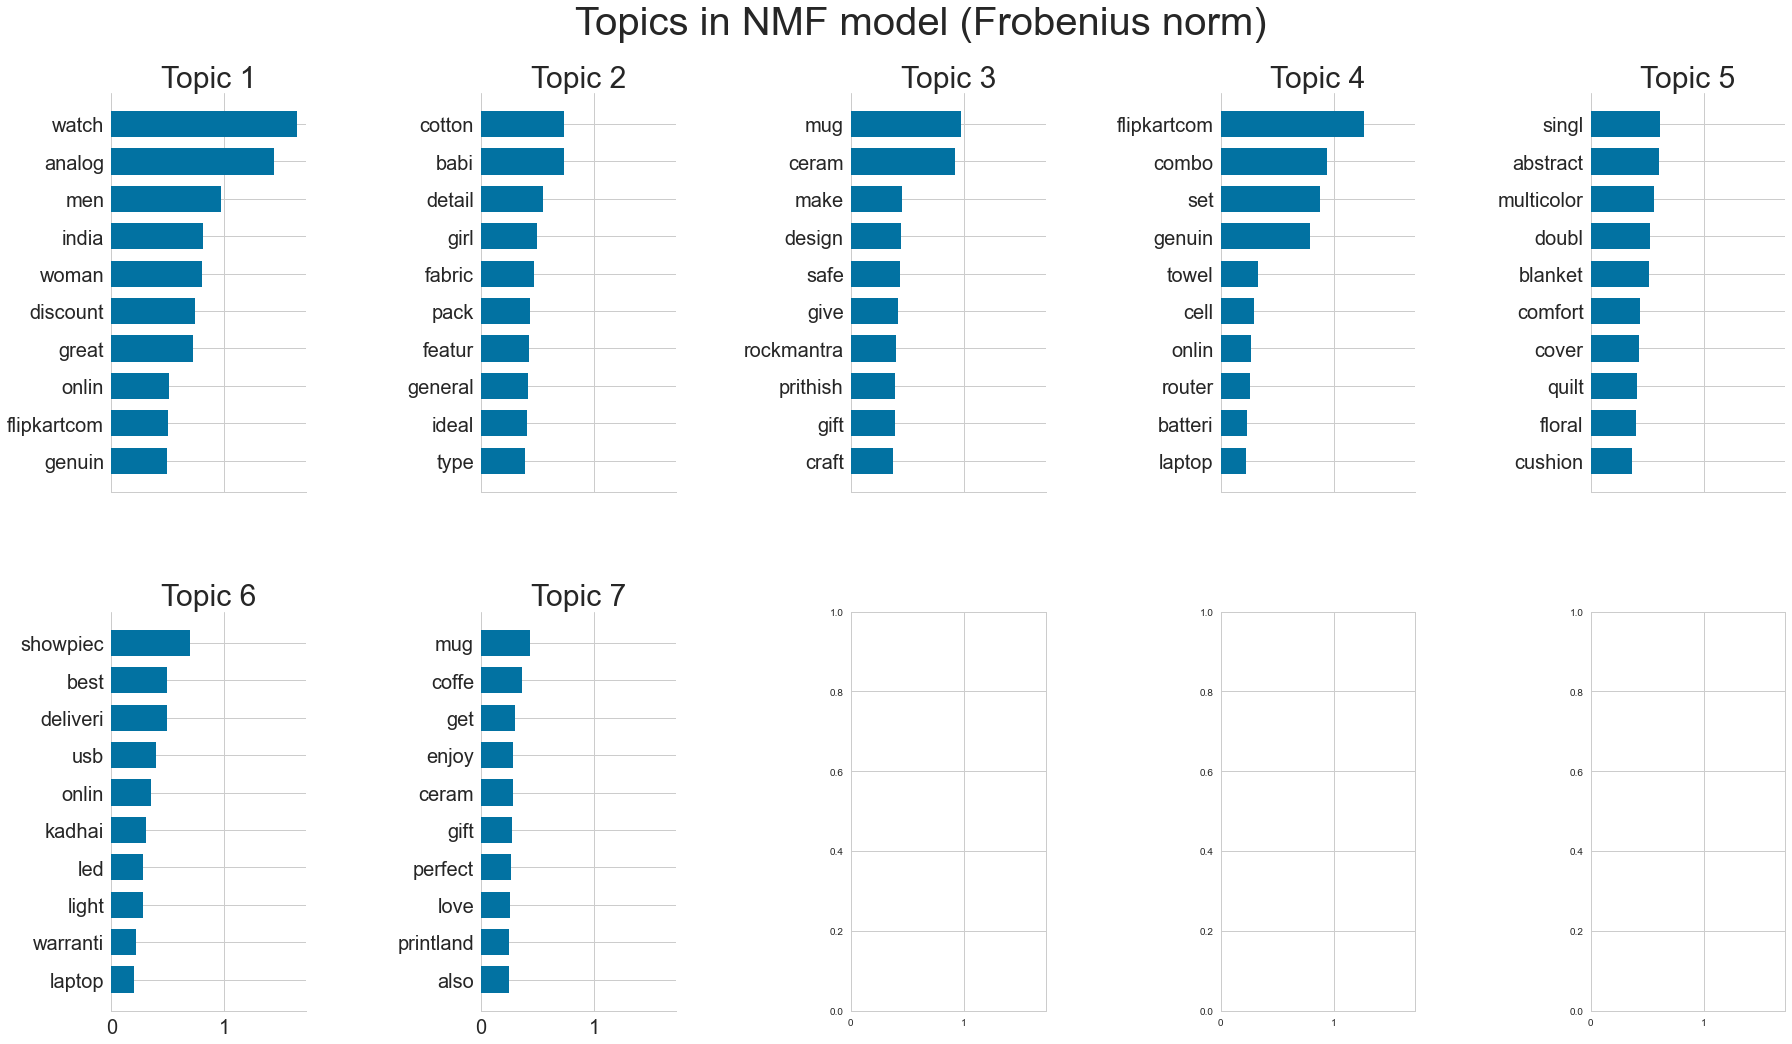



 Fitting LDA models with tf features, n_samples=1050 and n_features=1000...
done in 0.000s.


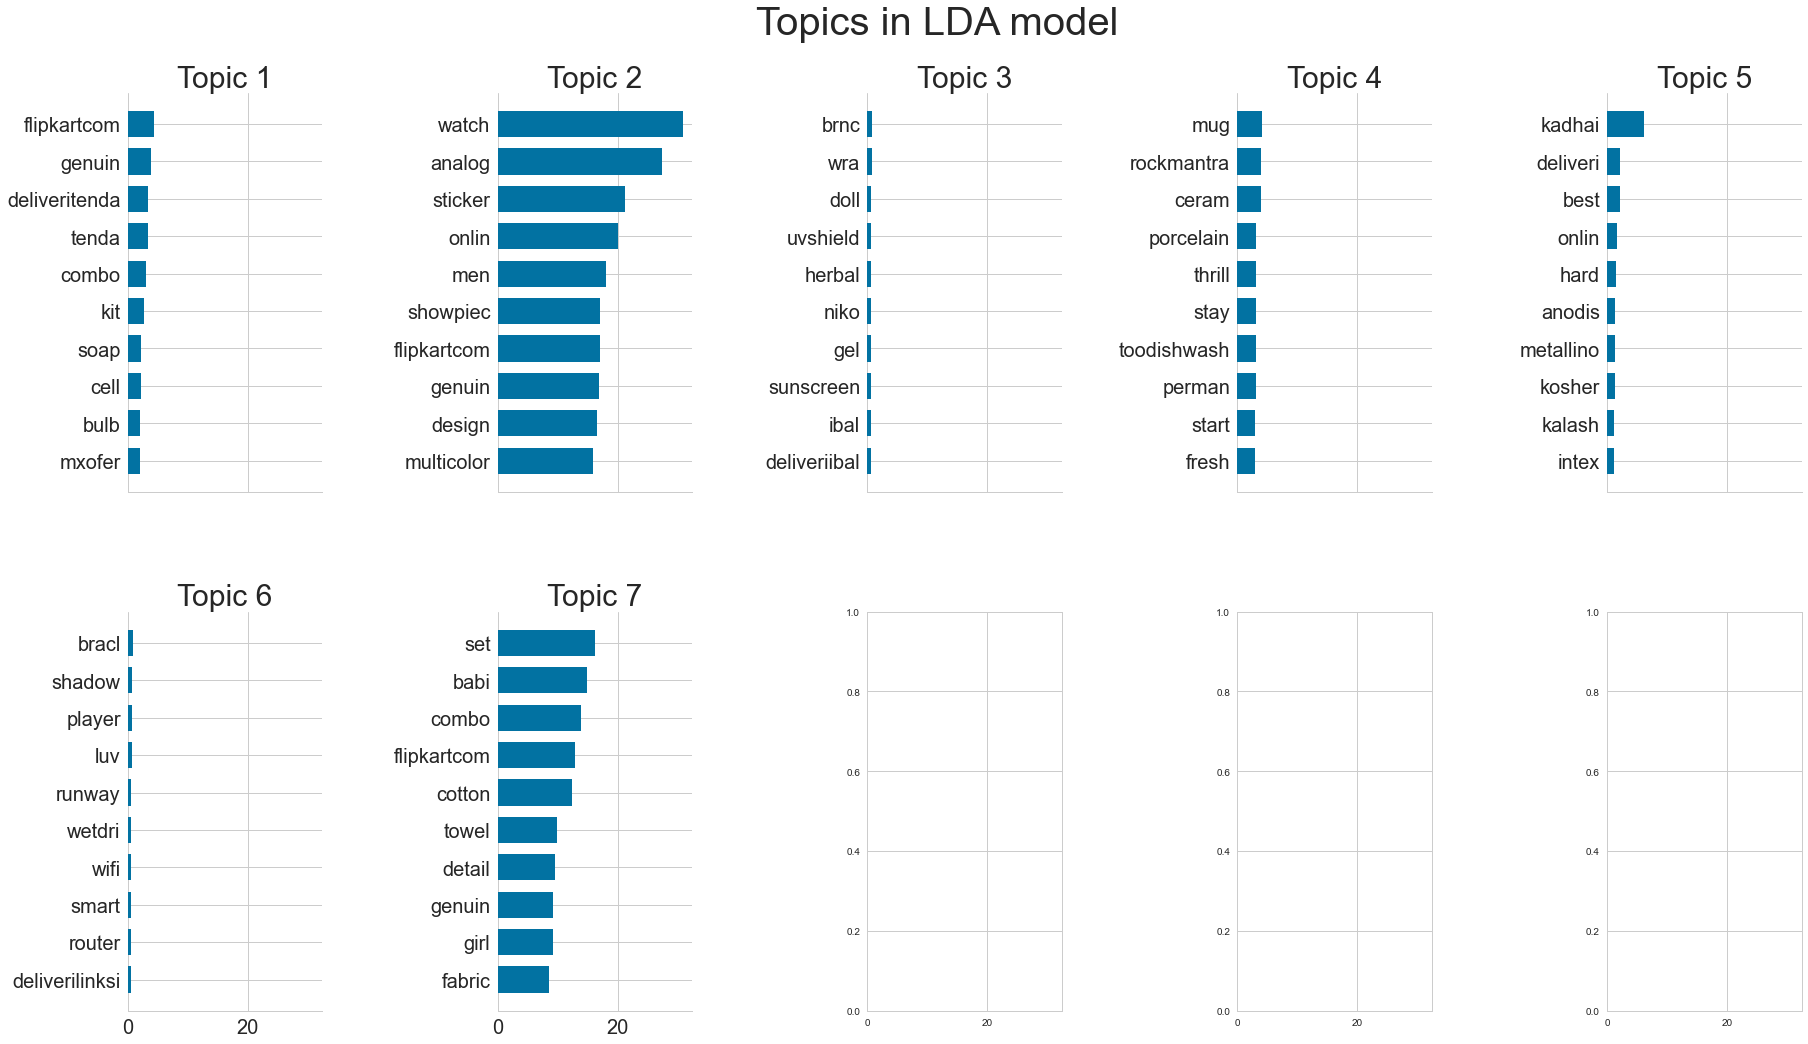

In [56]:
# Use tf-idf features for NMF and LDA.

# Fit the NMF model
print("Fitting the NMF model (kullback-leibler) with tf-idf features, "
      "n_samples=%d and n_features=%d..." % (n_samples, n_features))
t0 = time.time()
print("done in %0.3fs." % (time.time() - t0))
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")


# Fit the LDA model
print("\n" * 2, "Fitting LDA models with tf features, n_samples=%d and n_features=%d..." % (n_samples, n_features))
t0 = time.time()
print("done in %0.3fs." % (time.time() - t0))

tf_feature_names = tfidf_vect.get_feature_names_out()
plot_top_words(lda, tfidf_feature_names, n_top_words, "Topics in LDA model")

In [57]:
Z1 = lda.transform(tfidf_df)
Z2 = nmf.transform(tfidf_df)
pd.DataFrame(data=Z1, columns=['TOPIC'+ str(i) for i in range (1, n_topics+1)])

TOPIC1    TOPIC2    TOPIC3    TOPIC4    TOPIC5    TOPIC6    TOPIC7
0     0.014333  0.913945  0.014331  0.014373  0.014346  0.014332  0.014341
1     0.022573  0.740224  0.022573  0.022578  0.022573  0.022574  0.146906
2     0.016529  0.683828  0.016528  0.016545  0.016527  0.016530  0.233512
3     0.020584  0.876416  0.020583  0.020585  0.020585  0.020584  0.020663
4     0.017519  0.894833  0.017522  0.017521  0.017521  0.017519  0.017565
...        ...       ...       ...       ...       ...       ...       ...
1045  0.014175  0.914942  0.014175  0.014180  0.014176  0.014175  0.014178
1046  0.017100  0.897370  0.017100  0.017117  0.017101  0.017100  0.017111
1047  0.034733  0.791594  0.034731  0.034732  0.034735  0.034731  0.034743
1048  0.041405  0.751580  0.041400  0.041402  0.041409  0.041400  0.041406
1049  0.041021  0.753880  0.041016  0.041019  0.041026  0.041016  0.041022

[1050 rows x 7 columns]

In [58]:
pd.DataFrame(data=Z1, columns=['TOPIC'+ str(i) for i in range (1, n_topics+1)]).head(10)

TOPIC1    TOPIC2    TOPIC3    TOPIC4    TOPIC5    TOPIC6    TOPIC7
0  0.014333  0.913945  0.014331  0.014373  0.014346  0.014332  0.014341
1  0.022573  0.740224  0.022573  0.022578  0.022573  0.022574  0.146906
2  0.016529  0.683828  0.016528  0.016545  0.016527  0.016530  0.233512
3  0.020584  0.876416  0.020583  0.020585  0.020585  0.020584  0.020663
4  0.017519  0.894833  0.017522  0.017521  0.017521  0.017519  0.017565
5  0.036097  0.783392  0.036095  0.036088  0.036091  0.036091  0.036146
6  0.034659  0.792062  0.034647  0.034644  0.034645  0.034648  0.034695
7  0.021029  0.873713  0.021030  0.021034  0.021029  0.021031  0.021134
8  0.024145  0.413800  0.024144  0.024153  0.465452  0.024145  0.024162
9  0.026243  0.842596  0.026231  0.026226  0.026228  0.026230  0.026245

787


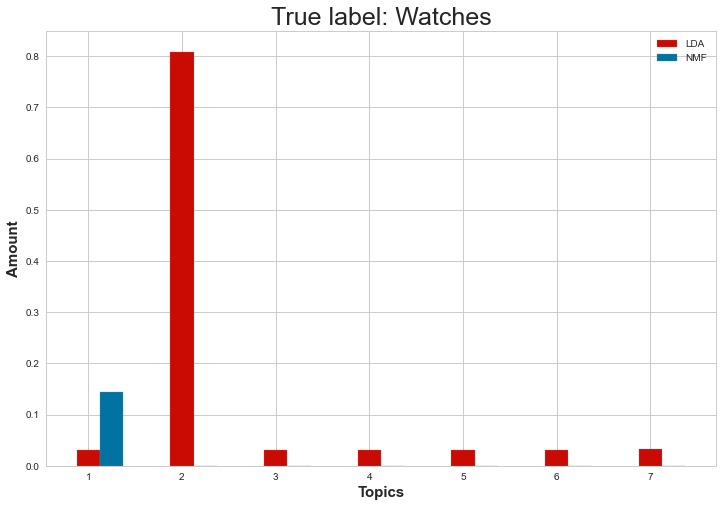

In [59]:
i = np.random.choice(len(df_desc))
print(i)
z1 = Z1[i]
z2 = Z2[i]

# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
topics = np.arange(7) + 1
br2 = [x + barWidth for x in topics]

# Make the plot
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(topics, z1, color ='r', width = barWidth,
        edgecolor ='grey', label ='LDA')
plt.bar(br2, z2, color ='b', width = barWidth,
        edgecolor ='grey', label ='NMF')
 
# Adding Xticks
ax.set_title('True label: %s' % df_desc.iloc[i]['cat_level_0'], size=25)
plt.xlabel('Topics', fontweight ='bold', fontsize = 15)
plt.ylabel('Amount', fontweight ='bold', fontsize = 15)

plt.legend()
plt.show()

## 4 - Word embedding

### a - Word2Vector

In [60]:
# To tokenize text
sentences = df_desc['text'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [61]:
# Create & train word2vec model
# Word2Vec prameters
min_count = 1
window    = 4
w2v_size  = 300
workers   = 4
w2v_epochs=100



print('Model training started...')
t0 = time.time()
w2v_model = Word2Vec(
    min_count   = min_count, #Ignore all the words where frequency of each word is less than min_count, default value is 5. As we wanted to add all words in corpus, so value we provided is 1.
    window      = window,    # Maximum distance between the current and predicted word within a sentence, default value is 5
    vector_size = w2v_size,  # Dimension of generated vector form of each word, by default size is 100.
    workers     = workers    # Uses those many threads to train the model. Default value is 3
)
# sg parameter : Used to choose the training algorithm: 1 for skip-gram; 0 for CBOW. By default CBOW is used for training.
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)

print('elapsed time is :', time.time()-t0)


Model training started...
elapsed time is : 3.821556568145752


In [62]:
print(w2v_model.wv.most_similar('mug'))
print(120*'_')
print('\n',w2v_model.wv.most_similar('cotton'))
print(120*'_')
print('\n',w2v_model.wv.most_similar('lip'))

[('ceram', 0.6394925713539124), ('coffe', 0.5932459831237793), ('prithish', 0.5058721899986267), ('akup', 0.4895015060901642), ('letter', 0.47585034370422363), ('genuinprithish', 0.4680699408054352), ('buffet', 0.4631391763687134), ('clay', 0.45690369606018066), ('keepcalm', 0.4568766951560974), ('volum', 0.4548855721950531)]
________________________________________________________________________________________________________________________

 [('babi', 0.5211741924285889), ('net', 0.43906378746032715), ('cotonex', 0.43856531381607056), ('towel', 0.43446817994117737), ('fabric', 0.4283657968044281), ('velvet', 0.4235522150993347), ('fur', 0.4218151569366455), ('diwan', 0.41168126463890076), ('bedsheet', 0.41016802191734314), ('grey', 0.4095393121242523)]
________________________________________________________________________________________________________________________

 [('liner', 0.8403427004814148), ('balm', 0.8253213763237), ('armani', 0.7909011840820312), ('pencilgiorgio', 

In [63]:
print ('similarity:',w2v_model.wv.similarity(w1='cotton', w2='babi'))
print('distance:',w2v_model.wv.distance('cotton','babi'))
cosine_similarity = 1 - spatial.distance.cosine(w2v_model.wv['cotton'], w2v_model.wv['babi'])
print('cosine similarity:', cosine_similarity)

similarity: 0.52117413
distance: 0.4788258671760559
cosine similarity: 0.5211740732192993


In [64]:
vec = w2v_model.wv['girl']- w2v_model.wv['woman']+ w2v_model.wv['man']
w2v_model.wv.most_similar(vec)

[('girl', 0.4806913435459137),
 ('chocoberri', 0.40824803709983826),
 ('drawer', 0.3942341208457947),
 ('branch', 0.3776768445968628),
 ('brnade', 0.3752926290035248),
 ('cottonspecif', 0.36617985367774963),
 ('mach', 0.36443039774894714),
 ('draweresteem', 0.3582087755203247),
 ('bland', 0.35755276679992676),
 ('netchinmay', 0.34914034605026245)]

In [65]:
w2v_vocab = w2v_model.wv.index_to_key
vocab_size = len(w2v_vocab) 
print("Vocabulary size: %i" % vocab_size)

# Préparation des sentences (tokenization)
maxlen = 100 # adapt to length of sentences
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
#Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_vocab:
        j +=1
        embedding_vector = w2v_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = w2v_model.wv[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

#Exécution du modèle
word2vec_df = embed_model.predict(x_sentences)
word2vec_df.shape


Vocabulary size: 4929
Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4930, 300)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          1479000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
Total params: 1,479,000
Trainable params: 1,479,000
Non-trainable params: 0
_________________________________________________________________


(1050, 300)

ARI :  0.586 time :  1.0


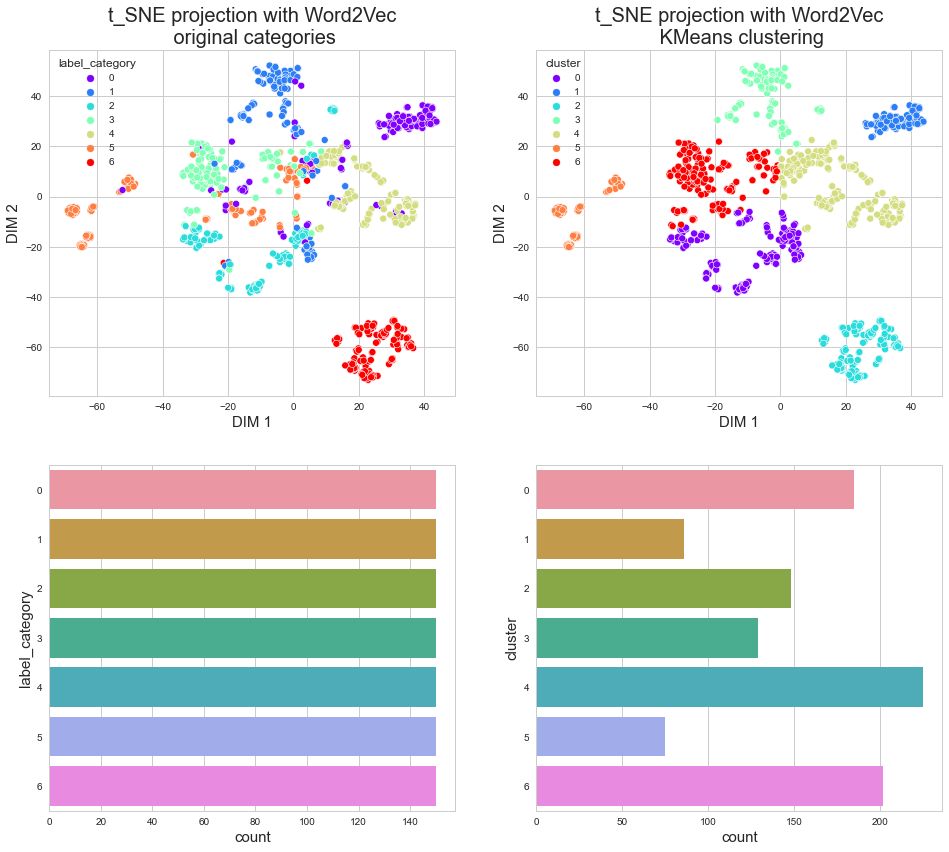

In [66]:
tsne_text(word2vec_df, 'Word2Vec')

ARI :  0.087 time :  1.0


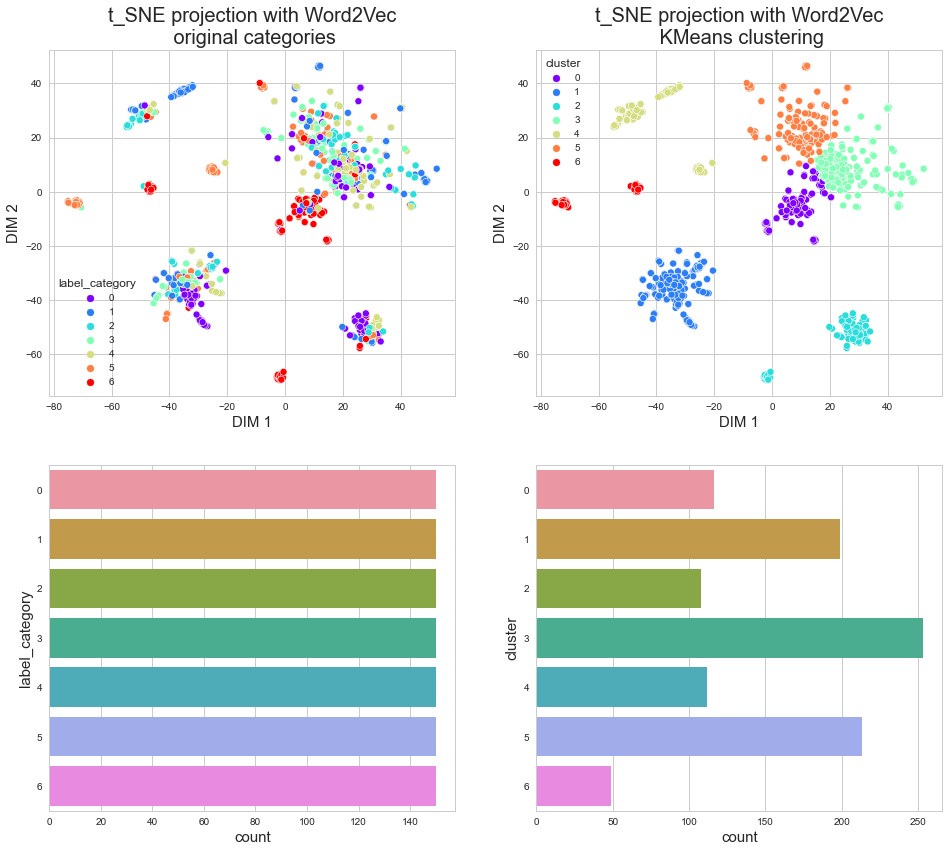

In [67]:
# Manual word2vec (method 1)
tokens = np.zeros(w2v_size)
doc_arr = []

for phrase in df_desc["text"] : 
    for word in gensim.utils.simple_preprocess(phrase):
        tokens += w2v_model.wv[word]
        tokens = tokens/len(phrase)
    doc_arr.append(tokens)    

doc_vect = pd.DataFrame(data=doc_arr, columns=['C' + str(c) for c in range(1, w2v_size+1, 1)])   
tsne_text(doc_vect, 'Word2Vec')

(1050, 300)
ARI :  0.452 time :  1.0


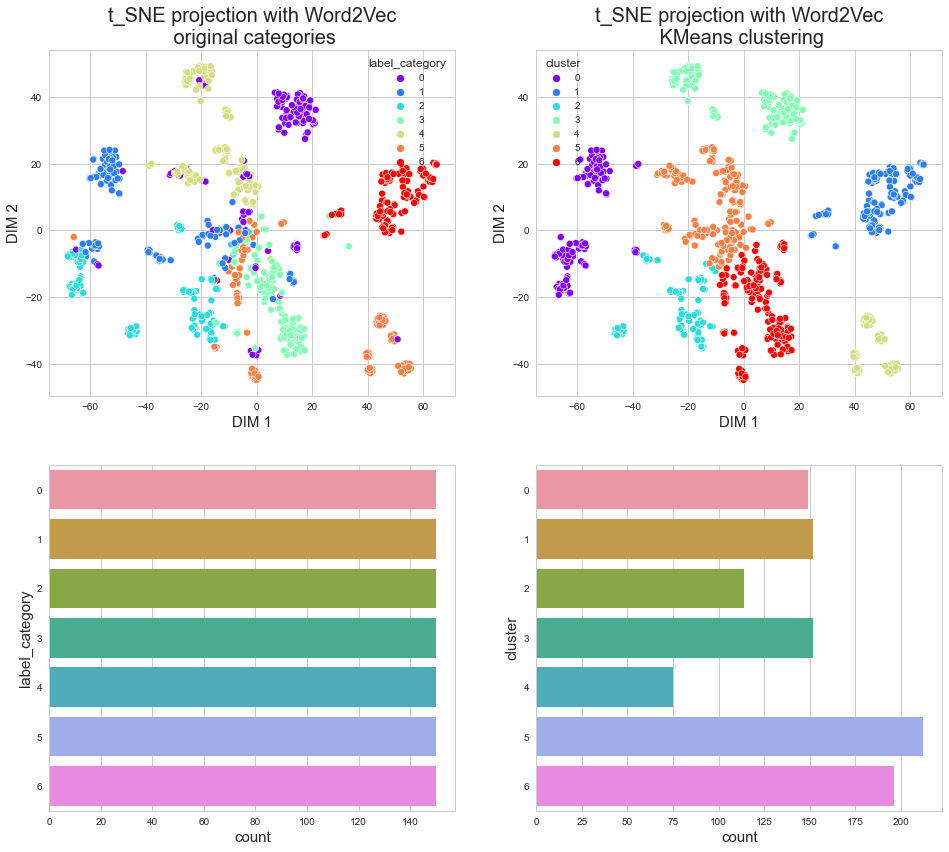

In [68]:
# Manual word2vec (method 2)

def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = pd.DataFrame(data=vectorize(sentences, model=w2v_model))
print(vectorized_docs.shape)
tsne_text(vectorized_docs, 'Word2Vec')

### b - Pre-trained model Word2vec

In [69]:
# download pre-trained model
trained = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
#dimension
trained.vectors.shape

(3000000, 300)

In [70]:
trained

In [71]:
def my_doc2vec (doc, model) :
    """
    """
    # dimension of representation 
    p = model.vectors.shape[1]
    #Vector initialization
    vec = np.zeros(p)
    #tokens number
    nb = 0
    #token treatment for each doc
    for tk in doc :
        try:
            values = model[tk]
            vec = vec + values
            nb = nb + 1
        except :
            pass
    if (nb > 0.0):
        vec = vec/nb
    return vec

In [72]:
docsVec = list()
for doc in df_desc['text'] : 
    vec = my_doc2vec(doc, trained)
    docsVec.append(vec)
    
matVec = np.array(docsVec)    
matVec.shape     

(1050, 300)

In [73]:
#Create Dataframe
pretrain_w2v_df = pd.DataFrame(data=matVec, columns=[['C' + str(c) for c in range(1, w2v_size+1, 1)]])
pretrain_w2v_df

C1        C2        C3        C4        C5        C6        C7  \
0    -0.184737  0.117645 -0.017109  0.137421 -0.059853  0.026697 -0.089911   
1    -0.179866  0.123978 -0.030995  0.136004 -0.056405  0.032247 -0.098486   
2    -0.189601  0.121297 -0.021030  0.139328 -0.047683  0.021266 -0.092531   
3    -0.177934  0.121626 -0.012666  0.139648 -0.056279  0.021581 -0.095433   
4    -0.178733  0.116667 -0.013876  0.145021 -0.061255  0.022792 -0.099662   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.169539  0.118671 -0.011879  0.143870 -0.053822  0.027300 -0.100547   
1046 -0.167860  0.116565 -0.009122  0.139510 -0.052778  0.037304 -0.086506   
1047 -0.163233  0.103615  0.008356  0.139729 -0.047214  0.041456 -0.081228   
1048 -0.153638  0.096682  0.000717  0.142800 -0.038060  0.050080 -0.079011   
1049 -0.153908  0.092040  0.039584  0.128094 -0.047489  0.057091 -0.067379   

            C8        C9       C10  ...      C291      C292      C293  \
0    -0.049432 -0.053052  0.018052  ...  0.063522 -0.006419 -0.094478   
1    -0.043049 -0.050400  0.015414  ...  0.067609  0.002706 -0.081956   
2    -0.045469 -0.038533  0.008961  ...  0.071543 -0.013846 -0.103337   
3    -0.046579 -0.045830  0.013708  ...  0.074709 -0.003670 -0.088942   
4    -0.049307 -0.044582  0.011603  ...  0.075332 -0.009183 -0.093138   
...        ...       ...       ...  ...       ...       ...       ...   
1045 -0.051169 -0.051503  0.003237  ...  0.068408 -0.021839 -0.125228   
1046 -0.049762 -0.049821  0.012065  ...  0.069531 -0.009636 -0.119979   
1047 -0.034662 -0.047677  0.031701  ...  0.066339 -0.006011 -0.114735   
1048 -0.060547 -0.030977  0.012846  ...  0.048482  0.009537 -0.111279   
1049 -0.072924 -0.049764  0.022712  ...  0.073791  0.002872 -0.098970   

          C294      C295      C296      C297      C298      C299      C300  
0     0.086313 -0.026650 -0.154879 -0.100883 -0.030432 -0.107903  0.154838  
1     0.101025 -0.017149 -0.157343 -0.105224 -0.031700 -0.114885  0.144448  
2     0.090182 -0.025180 -0.168894 -0.100165 -0.028376 -0.099128  0.168303  
3     0.105675 -0.022571 -0.163412 -0.115287 -0.026560 -0.119845  0.152848  
4     0.099348 -0.019658 -0.162216 -0.116009 -0.026387 -0.118737  0.154204  
...        ...       ...       ...       ...       ...       ...       ...  
1045  0.084028 -0.033357 -0.173136 -0.104114 -0.026127 -0.105395  0.163600  
1046  0.085888 -0.025281 -0.169600 -0.103936 -0.023738 -0.109755  0.151906  
1047  0.077250 -0.031750 -0.148819 -0.092627 -0.026714 -0.109388  0.135901  
1048  0.076797 -0.046372 -0.161170 -0.074187 -0.018946 -0.107799  0.125712  
1049  0.073868 -0.039965 -0.147653 -0.073374 -0.031080 -0.123563  0.166482  

[1050 rows x 300 columns]

ARI :  0.14 time :  1.0


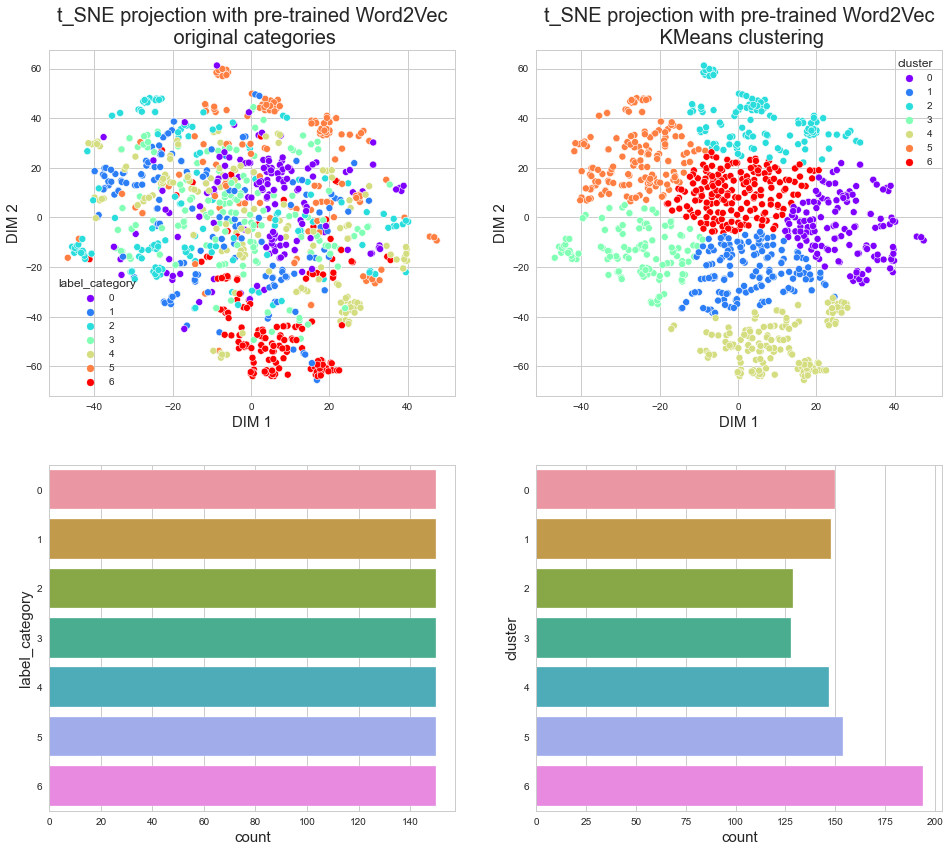

In [172]:
tsne_pretrained_w2v = tsne_text(pretrain_w2v_df, 'pre-trained Word2Vec')
tsne_pretrained_w2v

### c - BERT

In [75]:
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))
print(tensorflow.test.is_built_with_cuda())

Num GPUs Available:  0
True


In [76]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### i - BERT HuggingFace

In [77]:
max_length = 64
batch_size = 10
sentences = df_desc['text'].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


temps traitement :  80.0
ARI :  0.346 time :  1.0


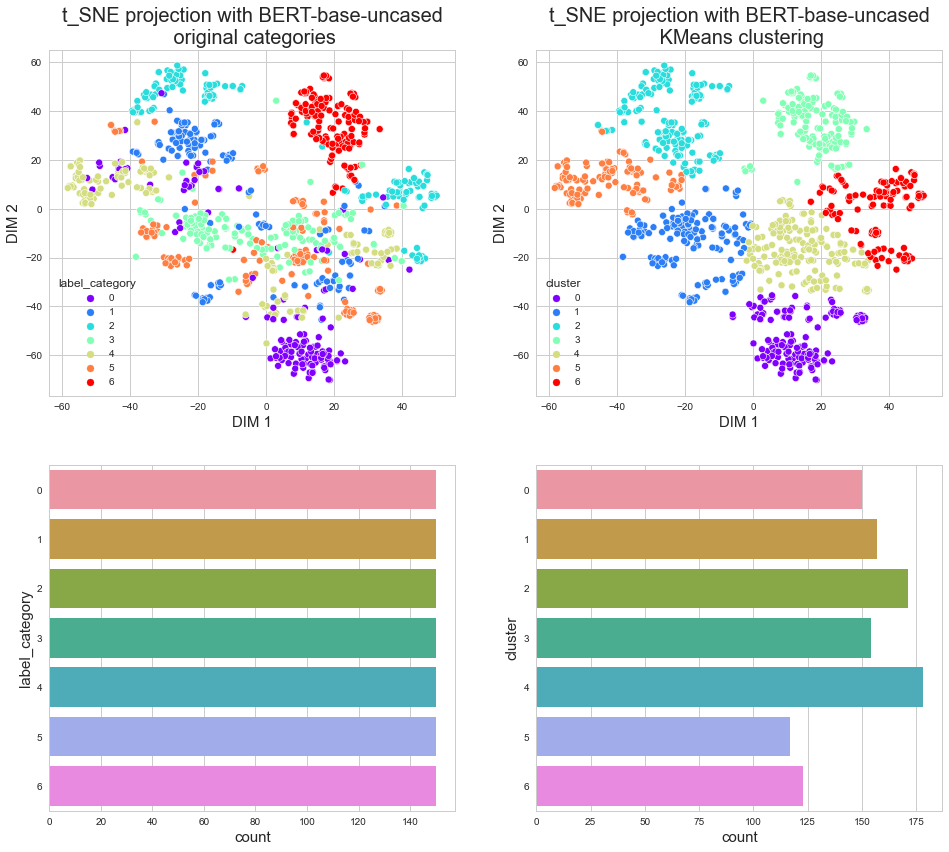

In [78]:
# To create model(bert-base-uncased)
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')
bert_df = pd.DataFrame(data=features_bert)
tsne_text(bert_df, 'BERT-base-uncased')

#### ii - BERT hub Tensorflow

In [79]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(
    model, model_type, sentences,
    max_length, batch_size, mode='TFhub'
)
bert_df = pd.DataFrame(data=features_bert)
tsne_text(bert_df, 'BERT-hub')

OSError: SavedModel file does not exist at: C:\Users\betas\AppData\Local\Temp\tfhub_modules\d760773f85f64fc84ae0b47310f7cfe3bcec4868\{saved_model.pbtxt|saved_model.pb}

### d - USE (Universal Sentence Encoder)

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
features_USE = feature_USE_fct(sentences, batch_size)
USE_df=pd.DataFrame(data=features_USE)
tsne_text(USE_df, 'USE')

# B - Computer vision

In [165]:
def tsne_image(vectorized_data, method): 
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=35)#, learning_rate=200, n_iter=3000, init='random')
    X_tsne = tsne.fit_transform(vectorized_data)
    tsne_columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)] 
    X_tsne  = pd.DataFrame (data = X_tsne, columns= tsne_columns)
   
    
    time1 = time.time()
    num_labels=len(list(set(df_desc['cat_level_0'])))
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    X_tsne = pd.merge(X_tsne, df_desc[['label_category']], on=X_tsne.index)
    X_tsne.drop('key_0', axis=1, inplace=True)
    X_tsne['cluster']=cls.labels_
    ARI = np.round(adjusted_rand_score(label_category, cls.labels_),3)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
  
    plt.style.use('seaborn-whitegrid')   
    plt.figure (figsize = (16,14))
    
    plt.subplot(2,2,1)
    sns.scatterplot (data=X_tsne, x='DIM1' , y='DIM2', hue='label_category', palette='rainbow')
    plt.title('t_SNE projection with '+ str(method) + '\n original categories', size=20)
    plt.xlabel('DIM 1', size=15)
    plt.ylabel('DIM 2', size=15)
 
    plt.subplot(2,2,2)
    sns.scatterplot (data=X_tsne, x='DIM1' , y='DIM2', hue='cluster', palette='rainbow')
    plt.title('t_SNE projection with '+ str(method) + '\n KMeans clustering', size=20)
    plt.xlabel('DIM 1', size=15)
    plt.ylabel('DIM 2', size=15)

    plt.subplot(2,2,3)
    sns.countplot(data=X_tsne, y='label_category', orient='h')
    plt.xlabel('count', size=15)
    plt.ylabel('label_category', size=15)

    plt.subplot(2,2,4)
    sns.countplot(data=X_tsne, y='cluster', orient='h')
    plt.xlabel('count', size=15)
    plt.ylabel('cluster', size=15)
    plt.show()
############################################

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(df_img)) if df_img["cat_level_0"][i]==name]
    return list_image_name
############################################

def gauss_blur(img, radius): 
    return cv2.GaussianBlur(img, (radius, radius),0)

def med_blur(img, radius):
    return cv2.medianBlur(img, radius)

def rgb_to_grey(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def fast_non_loc_means_denois(img):
    return cv2.fastNlMeansDenoising(img)
############################################
# Creation of histograms (features)
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# I - Images preprocessing

In [81]:
#
df_desc = df_desc.reset_index()
#
df_img = pd.concat([raw_df[['image']],df_desc[['cat_level_0','label_category']]], axis=1, ignore_index=False)
df_img

image      cat_level_0  label_category
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing               4
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care               0
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care               0
3     d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing               4
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing               4
...                                    ...              ...             ...
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care               0
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care               0
1047  5912e037d12774bb73a2048f35a00009.jpg        Baby Care               0
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care               0
1049  f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care               0

[1050 rows x 3 columns]

In [82]:
df_img['cat_level_0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

***************************** Home Furnishing ****************************


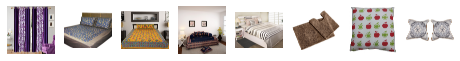

***************************** Baby Care ****************************


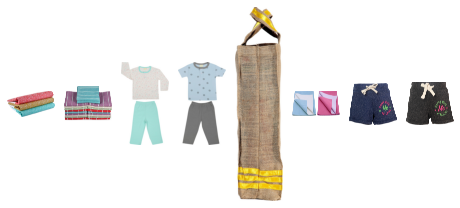

***************************** Watches ****************************


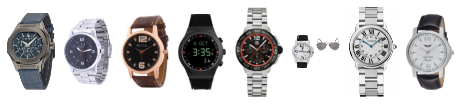

***************************** Home Decor & Festive Needs ****************************


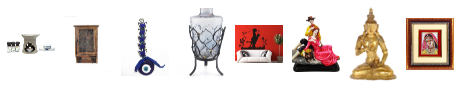

***************************** Kitchen & Dining ****************************


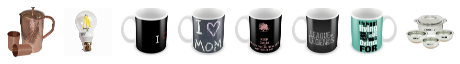

***************************** Beauty and Personal Care ****************************


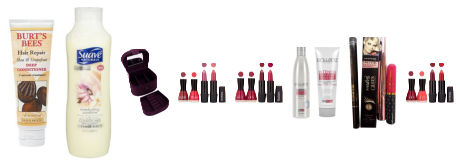

***************************** Computers ****************************


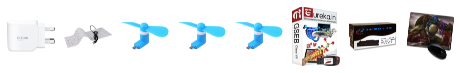

In [83]:
# Display photos for each category
path = 'C:/Users/betas/Downloads/Images/'
list_photos = df_img['image']
list_HomeFurnishing = [list_photos[i] for i in range(len(df_img)) if df_img["cat_level_0"][i]=="Home Furnishing"]
list_BabyCare = [list_photos[i] for i in range(len(df_img)) if df_img["cat_level_0"][i]=="Baby Care"]
list_Watches = [list_photos[i] for i in range(len(df_img)) if df_img["cat_level_0"][i]=="Watches"]
list_HomeDecor = [list_photos[i] for i in range(len(df_img)) if df_img["cat_level_0"][i]=="Home Decor & Festive Needs"]
list_Kitchen = [list_photos[i] for i in range(len(df_img)) if df_img["cat_level_0"][i]=="Kitchen & Dining"]
list_Beauty = [list_photos[i] for i in range(len(df_img)) if df_img["cat_level_0"][i]=="Beauty and Personal Cares"]
list_Computers = [list_photos[i] for i in range(len(df_img)) if df_img["cat_level_0"][i]=="Computers"]


for name in df_img['cat_level_0'].unique() :
    print('*****************************',name,'****************************')
    for i in range(8):
        sns.set_style('white')
        plt.subplot(180 + 1 + i)
        filename = path + list_fct(name)[i]
        image = imread(filename)
        plt.axis('off')
        plt.imshow(image)
    plt.show()

In [84]:
df_img[df_img['image']=='6ed4eb71c0707f1d6fdddcf62562cb02.jpg']

image       cat_level_0  label_category
628  6ed4eb71c0707f1d6fdddcf62562cb02.jpg  Kitchen & Dining               5

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

array([255, 255, 255], dtype=uint8)

the shape of image: (1100, 856, 3)


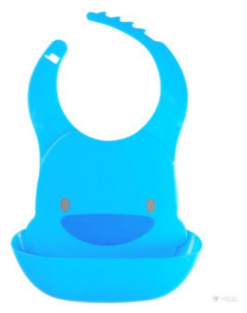

In [85]:
image = cv2.imread(path+list_photos[613])
display(image[0])
display(image[0,0])
plt.imshow(image)
plt.axis('off')
print('the shape of image:',image.shape)

(array([ 347664.,   47847.,    7884.,    5242.,    4751.,   36592.,
          29907.,  248633.,  125950., 1970330.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

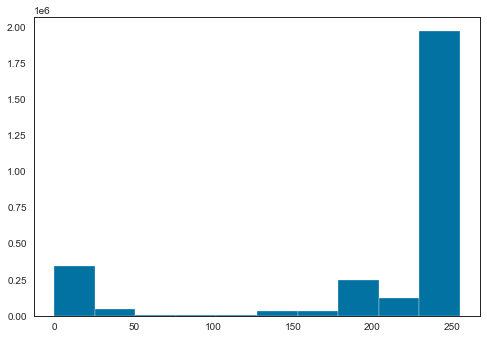

In [86]:
plt.hist(image.flatten())

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

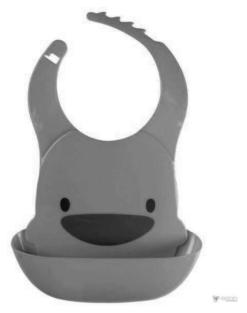

In [87]:
image = cv2.imread(path+list_photos[613],0) # convert in gray
# To convert to gray we can use also cv2.imread(path+list_photos[0], cv2.IMREAD_GRAYSCALE)
display(image)
plt.axis('off')
plt.imshow(image, cmap='gray')

Text(0, 0.5, 'Pixels number')

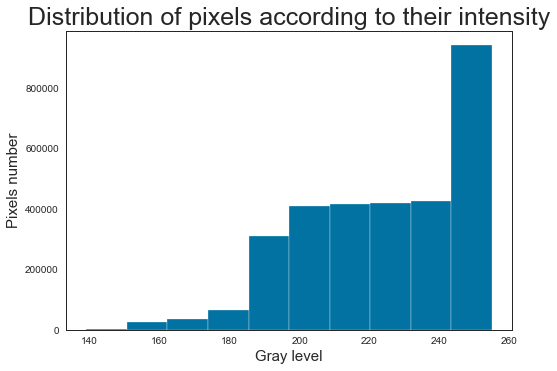

In [88]:
plt.hist(image.flatten(), cumulative=True)
plt.title('Distribution of pixels according to their intensity', size=25)
plt.xlabel('Gray level', size=15)
plt.ylabel('Pixels number', size=15)

(-0.5, 855.5, 1099.5, -0.5)

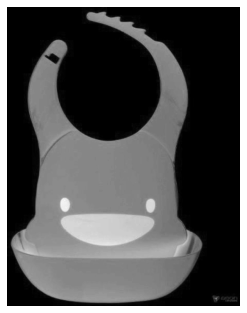

In [89]:
# To dispaly negative image
plt.imshow(255 - image, cmap = 'gray')
plt.axis('off')

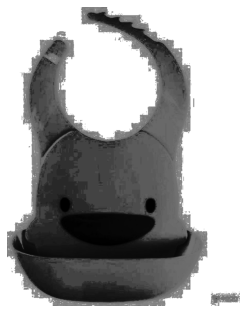

In [90]:
image = cv2.equalizeHist(image)
plt.axis('off')
plt.imshow(image, cmap='gray')

Text(0, 0.5, 'Pixels number')

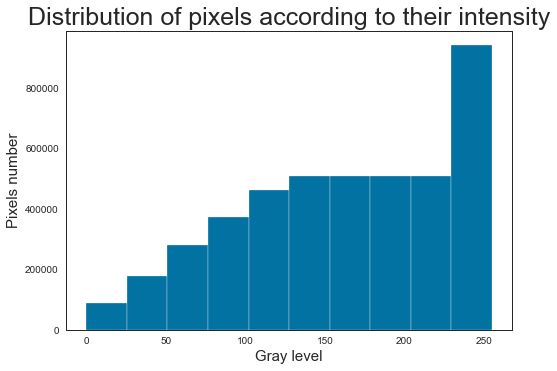

In [91]:
plt.hist(image.flatten(), cumulative=True)
plt.title('Distribution of pixels according to their intensity', size=25)
plt.xlabel('Gray level', size=15)
plt.ylabel('Pixels number', size=15)

# II - Images modelling

## 1 - Features extraction with SIFT
* Each image contains a number of descriptors
* Each descriptor is a vector shaped 128

### a - Example of one image

Shape of Descriptors :  (1414, 128)
Keypoints :  1414
Iage descriptor : [[10.  3.  1. ...  0.  0.  0.]
 [ 5.  9.  2. ...  0.  1.  5.]
 [ 8.  3.  0. ...  1.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  1. 32.]
 [16. 25. 10. ...  8. 37. 10.]
 [ 0.  0.  0. ...  0.  0.  0.]]
The first key point : <KeyPoint 000001BF17542870>


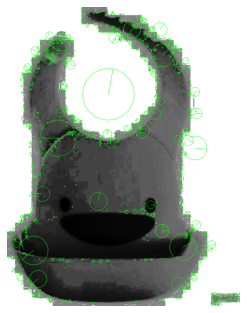

In [92]:
# reading image and convert in to gray
input_image = cv2.imread(path+list_photos[613],0) 
# equalize image histogram
input_image = cv2.equalizeHist(input_image)  

# using the SIFT algorithm to detect key
# points in the image
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(input_image, None)

# drawKeypoints function is used to draw keypoints
output_image = cv2.drawKeypoints(input_image,kp,0, (0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# displaying the image with keypoints as the output on the screen
plt.imshow(output_image)
plt.axis('off')
print("Shape of Descriptors : ", des.shape)
print("Keypoints : ", len(kp))
print('Iage descriptor :', des)
print('The first key point :', kp[0])

### b - Feature Matching

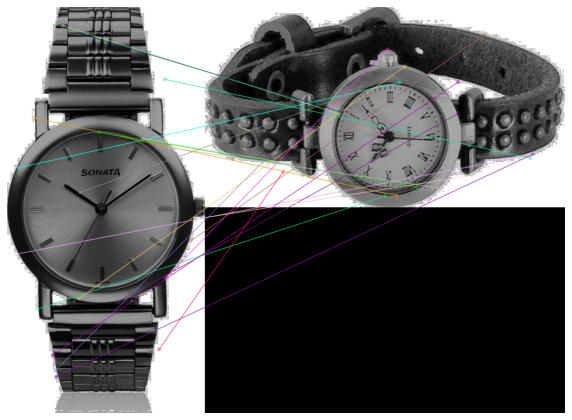

In [93]:
# read images, convert to gray & equalize histogram
img1 = cv2.imread(path+list_photos[557], 0)  
img2 = cv2.imread(path+list_photos[573], 0) 
img1 = cv2.equalizeHist(img1)
img2 = cv2.equalizeHist(img2)

#sift
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:20], img2, flags=2)
plt.figure(figsize=(10,10))
plt.imshow(img3)
plt.axis('off')
plt.show()


### c - Descriptors for all images ??? To explain
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs
Send the visual dictionary to the k-means clustering algorithm and find the visual words which are center points.
Extracts local features from images using SIFT. The below function returns an array whose first index holds a list that holds all local features from all images without an order. This is our visual dictionary. And the second index holds the sift vectors dictionary which holds the descriptors but this is separated class by class
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
    
    
Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [94]:
# To get descriptors for all images
# identification of key points and associated descriptors
sift_keypoints = []
t0 = time.time()
sift = cv2.SIFT_create()

for image_num in range(len(list_photos)) :
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)
    
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)  
print()
print("Total descriptors : ", sift_keypoints_all.shape)

duration = time.time()-t0
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration, "secondes")


Total descriptors :  (9051349, 128)
temps de traitement SIFT descriptor :           572.74 secondes


In [95]:
# Descriptors clustering_visual words
# Determination number of clusters
t0=time.time()

#k = int(round(np.sqrt(len(sift_keypoints_all)),0))
k = 70
print("Estimated number of clusters : ", k)
print("Creation of",k, "clusters of descriptors ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration = time.time() - t0
print("temps de traitement kmeans : ", "%15.2f" % duration, "secondes")

Estimated number of clusters :  70
Creation of 70 clusters of descriptors ...
temps de traitement kmeans :            45.49 secondes


In [96]:
## Images features creation
t0 = time.time()
# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration = time.time()-t0
print("temps de création histogrammes : ", "%15.2f" % duration, "secondes")


temps de création histogrammes :           107.73 secondes


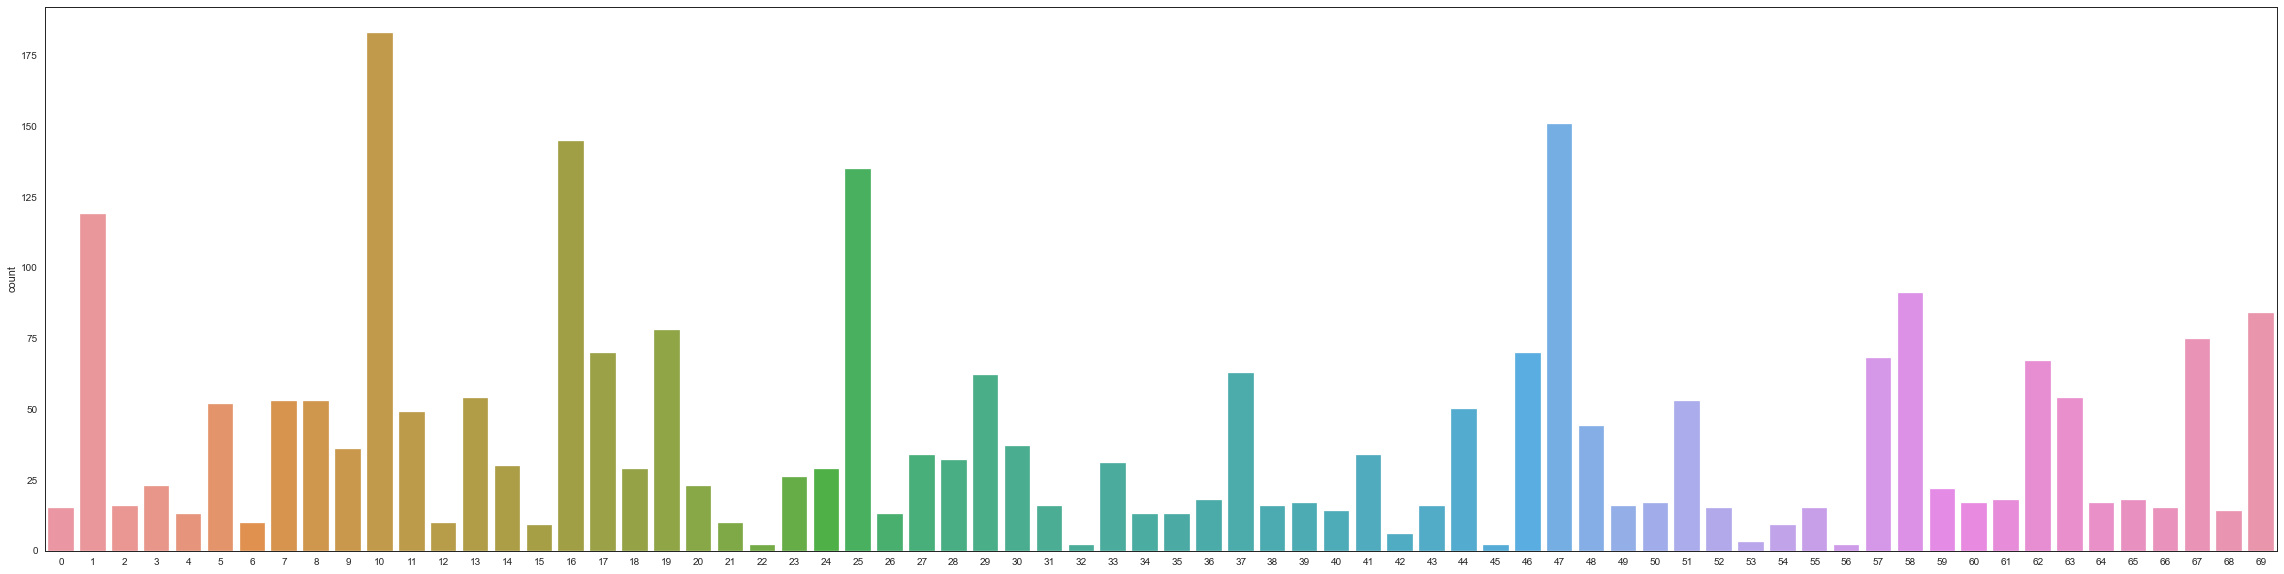

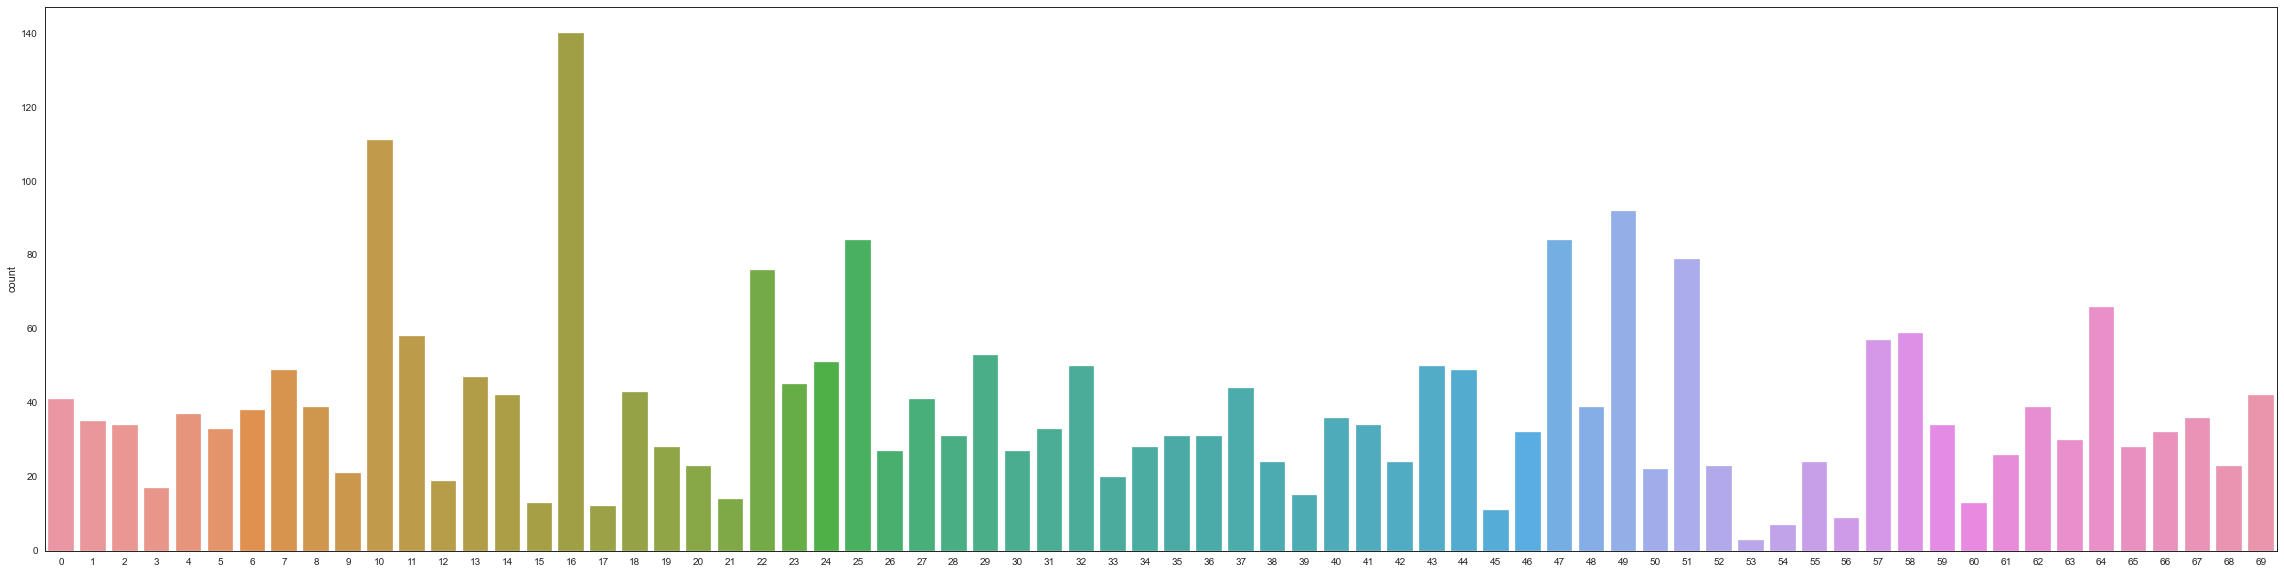

In [97]:
#To get & compare histograms for similar images 
img1 = cv2.imread(path+list_photos[845], 0)  
img2 = cv2.imread(path+list_photos[592], 0) 
img1 = cv2.equalizeHist(img1)
img2 = cv2.equalizeHist(img2)

#sift
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

# To display histograms
plt.figure(figsize=(40,10))
sns.countplot(kmeans.predict(descriptors_1))
plt.show()
plt.figure(figsize=(40,10))
sns.countplot(kmeans.predict(descriptors_2))
plt.show()


ARI :  0.041 time :  1.0


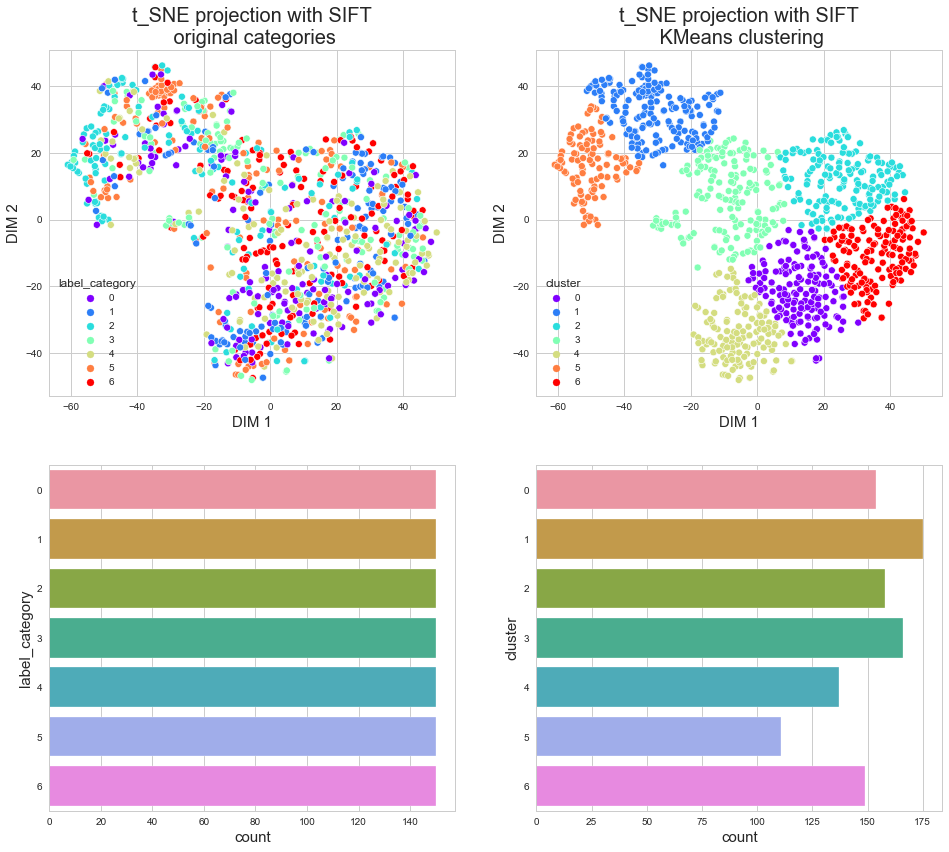

In [167]:
# Clustering with t-SNE reduction
visual_words_df = pd.DataFrame(data=im_features)
tsne_image(visual_words_df, 'SIFT')

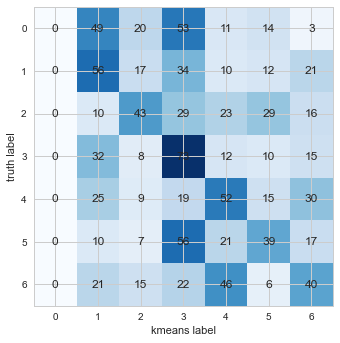

In [99]:
# Confusion matrix
matrix(visual_words_df)

## 2 - Features extraction with ORB

In [100]:
# To get descriptors for all images
# identification of key points and associated descriptors
orb_keypoints = []
t0 = time.time()
orb = cv2.ORB_create()

for image_num in range(len(list_photos)) :
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)
    
orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)  
print()
print("Total descriptors : ", orb_keypoints_all.shape)

duration = time.time()-t0
print("temps de traitement ORB descriptor : ", "%15.2f" % duration, "secondes")


Total descriptors :  (520145, 32)
temps de traitement ORB descriptor :            38.58 secondes


In [101]:
# Descriptors clustering_visual words
# Determination number of clusters
t0=time.time()

#k = int(round(np.sqrt(len(orb_keypoints_all)),0))
k = 70
print("Estimated number of clusters : ", k)
print("Creation of",k, "clusters of descriptors ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration = time.time() - t0
print("temps de traitement kmeans : ", "%15.2f" % duration, "secondes")

Estimated number of clusters :  70
Creation of 70 clusters of descriptors ...
temps de traitement kmeans :             3.21 secondes


In [102]:
# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration = time.time()-t0
print("temps de création histogrammes : ", "%15.2f" % duration, "secondes")


temps de création histogrammes :           104.92 secondes


ARI :  0.037 time :  1.0


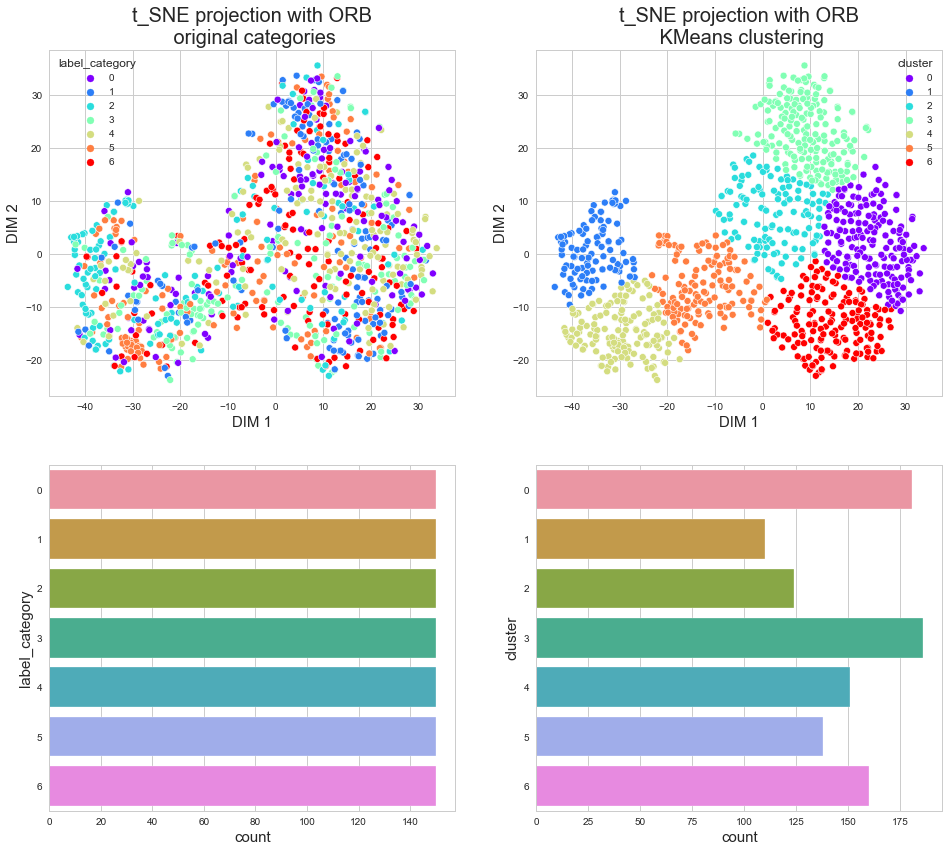

In [103]:
# Clustering with t-SNE reduction
visual_words_df = pd.DataFrame(data=im_features)
tsne_image(visual_words_df, 'ORB')

## 3 - Features extraction with CNN-transfer learning

### a - VGG16

In [104]:
min_w, min_h = 10000, 10000

for i in range(len(list_photos)) : 
    raw_image = cv2.imread(path + list_photos[i])
    if raw_image.shape[0] < min_h :
        min_h = raw_image.shape[0]
    if raw_image.shape[1] < min_w :
        min_w = raw_image.shape[1]
min_h, min_w        

(160, 145)

In [105]:
# Import and reshape images
input_image = []
for i in range(len(list_photos)) : 
    raw_image = cv2.imread(path + list_photos[i])
    image = cv2.resize(raw_image,(128,128))
    #image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image = preprocess_input(image)
    input_image.append(image)
    
# Transform to an array
input_image = np.array(input_image)
#Normalize th array
#input_image = input_image.astype('float32')/ 255

display(input_image[0][0][0])    
print('The shape ov input images :', input_image.shape)    

array([103.061,  85.221,  71.32 ], dtype=float32)

The shape ov input images : (1050, 128, 128, 3)


In [106]:
# Download pre_trained VGG-16 on ImageNet without fully connected layers
model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(128,128,3)))
print('Output of model:', model.output)
model.summary()


Output of model: KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2

In [107]:
def features_extraction(model) :
    features = model.predict(input_image)
    print(features.shape)
    features = features.reshape(1050,-1)
    print(features.shape)
    return  pd.DataFrame(data=features)    

In [108]:
VGG16_df = features_extraction(model)

(1050, 4, 4, 512)
(1050, 8192)


ARI :  0.369 time :  1.0


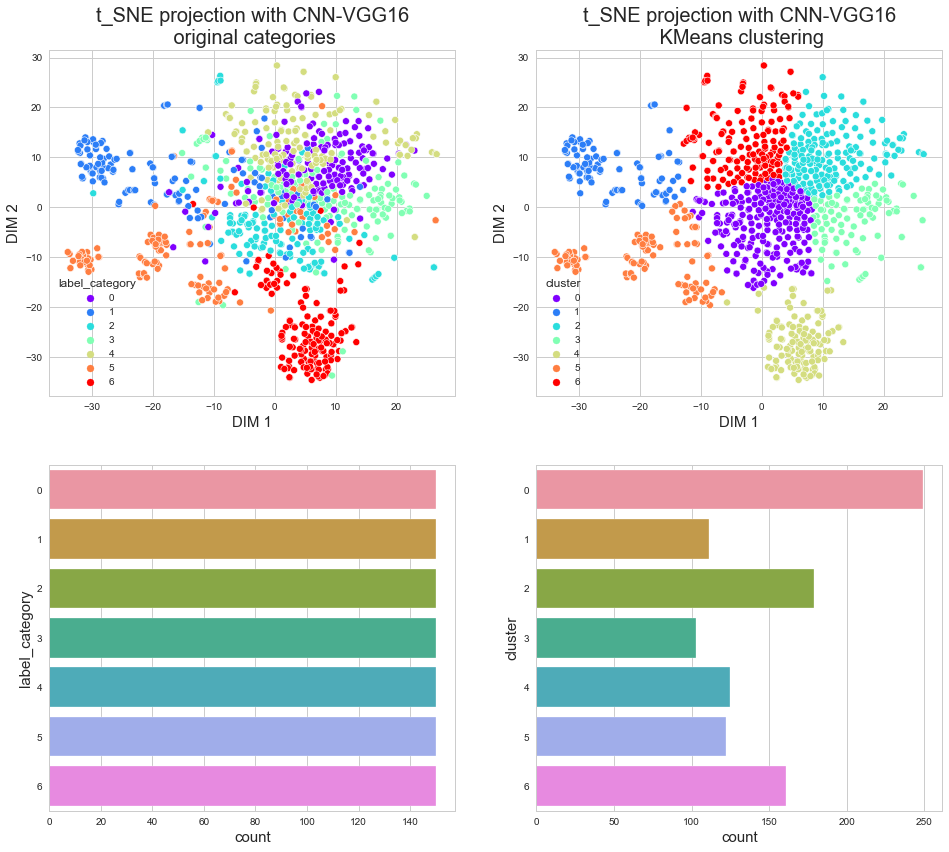

In [109]:
tsne_image(VGG16_df,'CNN-VGG16')

### b - RestNet50

In [110]:
model = ResNet50(weights='imagenet', input_shape=(128,128,3), include_top=False)
print('Output of model:', model.output)
model.summary()

Output of model: KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
c

In [111]:
ResNet50_df = features_extraction(model)

(1050, 4, 4, 2048)
(1050, 32768)


ARI :  0.381 time :  1.0


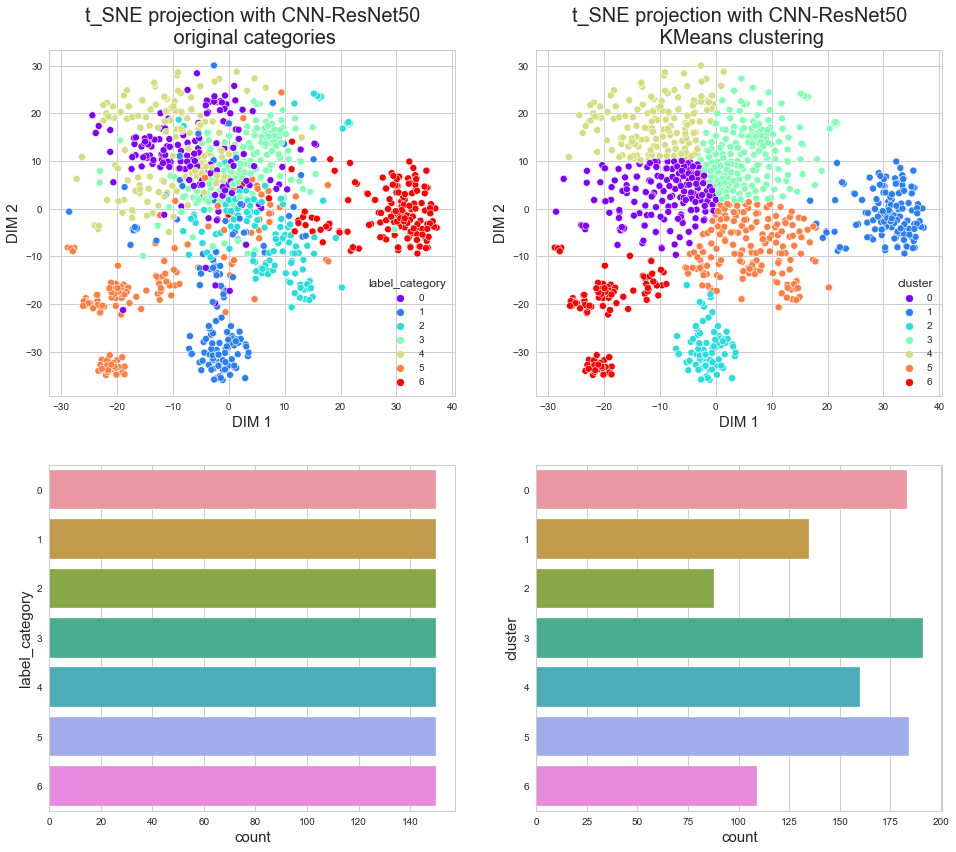

In [112]:
tsne_image(ResNet50_df,'CNN-ResNet50')

# III -  Classification with Pre-entrained VGG 16

In [113]:
model = VGG16()

In [114]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

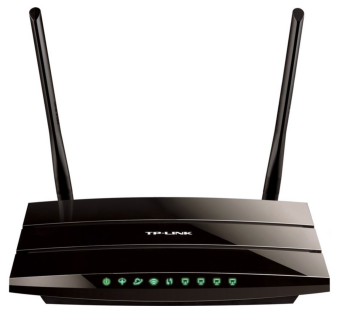

In [115]:
plt.axis('off')
plt.imshow(cv2.imread(path+list_photos[400]))

In [116]:
input_image = cv2.imread(path + list_photos[400])
input_image = cv2.resize(input_image,(224,224))
input_image = input_image.reshape(1,input_image.shape[0],input_image.shape[1],input_image.shape[2])
prediction = model.predict(input_image)
label = decode_predictions(prediction)
label

[[('n03777754', 'modem', 0.58392256),
  ('n04041544', 'radio', 0.41580105),
  ('n03759954', 'microphone', 0.00025931688),
  ('n03832673', 'notebook', 4.2053684e-06),
  ('n04141975', 'scale', 3.281003e-06)]]

# C - Text & Description clustering

In [159]:
text_image_df = pd.concat([pd.DataFrame(data=word2vec_df),ResNet50_df], axis=1)
text_image_df

0         1         2         3         4         5         6      \
0     0.025129 -0.002875 -0.001575  0.358812  0.271873  0.172877 -0.239869   
1     0.034916  0.043186 -0.131259  0.004152  0.337858 -0.209191 -0.021531   
2    -0.119627 -0.085242  0.111103  0.073313  0.466061 -0.239033 -0.042060   
3     0.188987 -0.099151 -0.351525 -0.286506  0.863457 -0.024282 -0.046026   
4    -0.003217 -0.045236 -0.143317 -0.359370  0.844396  0.107906 -0.007377   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.197661  0.251889 -0.298443  0.072673 -0.290251 -0.167021  0.169194   
1046 -0.015340  0.069966 -0.291956  0.124034  0.080725 -0.173450  0.097438   
1047  0.057903  0.097697 -0.162210  0.062731 -0.021528 -0.026427  0.108470   
1048  0.116669  0.036337 -0.142284  0.053570  0.039321 -0.060307  0.084010   
1049  0.047572  0.049128 -0.112878  0.020699  0.032566 -0.023700  0.092278   

         7         8         9      ...      32758  32759     32760     32761  \
0     0.302040  0.506138  0.022725  ...   3.107474    0.0  0.000000  0.000000   
1     0.495255  0.281572 -0.043183  ...   0.000000    0.0  0.000000  0.000000   
2     0.800524  0.203927  0.017570  ...   2.001400    0.0  0.000000  0.000000   
3     0.603120  0.486151 -0.140780  ...   0.000000    0.0  0.000000  0.000000   
4     0.614359  0.351732 -0.001899  ...   0.000000    0.0  0.000000  0.000000   
...        ...       ...       ...  ...        ...    ...       ...       ...   
1045 -0.002010 -0.157333 -0.163222  ...   0.000000    0.0  0.000000  0.000000   
1046  0.087367  0.113150 -0.045733  ...  16.565002    0.0  0.542027  0.630714   
1047  0.019984  0.106050 -0.169931  ...   0.000000    0.0  0.000000  0.000000   
1048 -0.011803  0.129356 -0.161985  ...   8.305255    0.0  0.000000  0.378343   
1049  0.026444  0.088792 -0.132292  ...   0.000000    0.0  0.000000  0.000000   

          32762     32763     32764     32765     32766     32767  
0      0.000000  0.000000  0.000000  0.000000  2.463367  0.000000  
1      0.457202  0.000000  0.000000  0.000000  0.000000  0.000000  
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...         ...       ...       ...       ...       ...       ...  
1045   0.000000  0.077098  0.000000  0.185628  0.000000  0.304952  
1046  13.687475  0.000000  0.000000  0.000000  0.000000  0.000000  
1047   0.053031  0.000000  2.571208  1.459134  0.000000  0.000000  
1048   1.133325  0.000000  0.000000  1.130514  0.000000  0.000000  
1049   0.000000  0.000000  0.204199  3.471346  1.177218  0.000000  

[1050 rows x 33068 columns]

ARI :  0.408 time :  1.0


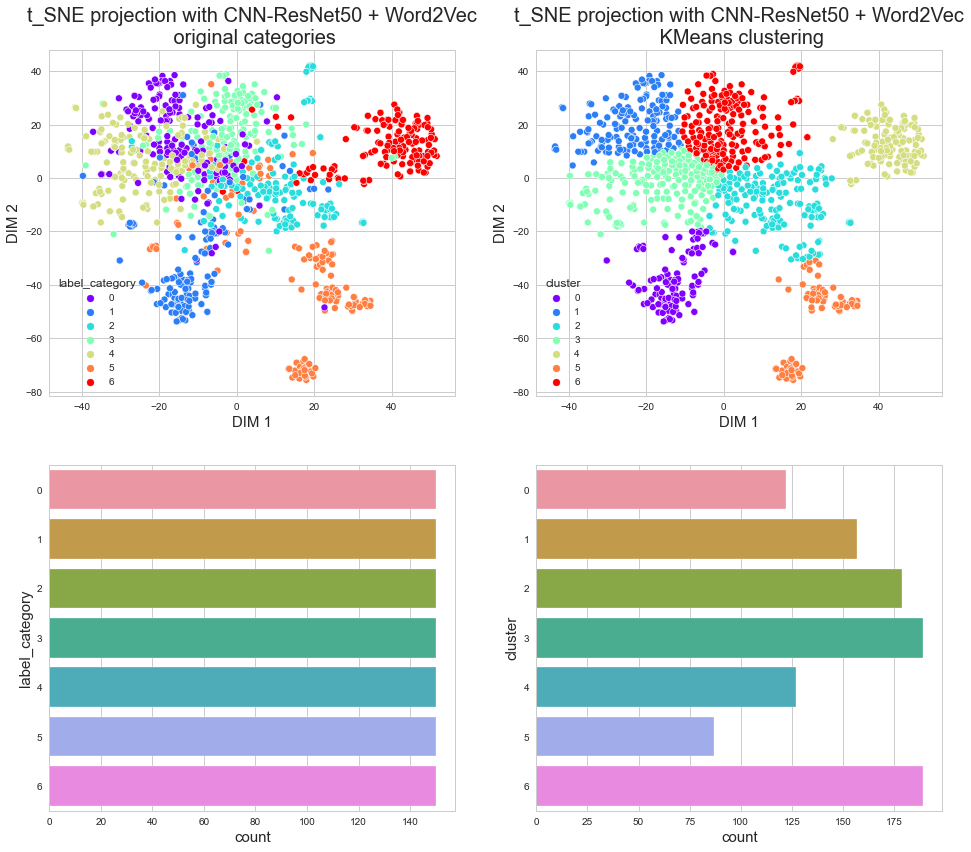

In [170]:
tsne_text(text_image_df,'CNN-ResNet50 + Word2Vec')